## FC for Widespread Pain Subjects
#### Input: *stc.mat
####  Output: con, visualization

In [1]:
import os
from pathlib import Path
import sys
import mne 
from mne.datasets import fetch_fsaverage
fs_dir = fetch_fsaverage(verbose=True)
subject = "fsaverage"
subjects_dir = os.path.dirname(fs_dir)
sys.path.append("/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/")
from eeg_toolkit import preprocess, utils
import eeg_toolkit.functional_connectivity as fc

0 files missing from root.txt in /home/wanglab/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage
0 files missing from root.txt in /home/wanglab/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/wanglab/mne_data/MNE-fsaverage-data/fsaverage


In [2]:
# Settings
times_tup, time_win_path = preprocess.get_time_window(5)

# data paths
data_dir = Path("../../Data")
processed_data_path = data_dir / "Processed Data"
stc_path = data_dir / "Source Time Courses"
EO_resting_data_path = stc_path / "Eyes Open"
EC_resting_data_path = stc_path / "Eyes Closed"
zscored_epochs_data_path = stc_path / "zscored_Epochs" / time_win_path

# save paths
subset = "Widespread_Pain"
fc_path = data_dir / "Functional Connectivity"
fc_subset_path = fc_path / subset
save_path = fc_subset_path

os.makedirs(save_path, exist_ok=True)

[-2.5,0.0,2.5]


### Get CLBP WSP from viable subject IDs

In [3]:
# viable subjects
sub_ids = utils.import_subs(data_dir, "sub_ids.txt")
sub_ids = sub_ids[7:]  # select only 64ch subs and turn into set
sub_ids_CP_WSP = [el for el in sub_ids if el.startswith('0')]
sub_ids_HC = [el for el in sub_ids if el.startswith('C')]

# CP Subs with widespread pain
widespread_pain_CP = [
    '055',
    '052',
    '046',
    '039',
    '036',
    '031',
    '022',
    '045',
    '040',
    '034',
    '032',
    '024',
    '018'
]

# Sort and limit CP subs to only those with widespread pain
widespread_pain_CP.sort()
sub_ids_CP_WSP = widespread_pain_CP

# Exclude HEALTHY subjects with widespread pain
widespread_pain_HC = ['C1.','C23']
sub_ids_HC = [sub for sub in sub_ids_HC if sub not in widespread_pain_HC]

# Combine selected CP and HC subjects
sub_ids = sub_ids_CP_WSP + sub_ids_HC

# Exclude subjects with NaN source localization
NAN_SUBS = ['018','021','C1.','C2.','C3.']
sub_ids = [sub for sub in sub_ids if sub not in NAN_SUBS]

exclude_resting=True

# These subjects have no keypresses and thus no resting timestamps, but they do have epoched data
# TODO: estimate eyes open timestamps from alpha band power
NO_KEYPRESS = ['045', 'C1.', 'C5.', 'C8.', 'C20', 'C21', 'C22']
sub_ids = [sub for sub in sub_ids if sub not in NO_KEYPRESS]

In [4]:
sub_ids_CP_WSP = [el for el in sub_ids if el.startswith('0')]
sub_ids_HC = [el for el in sub_ids if el.startswith('C')]

print(f"Chronics: {len(sub_ids_CP_WSP)}")
print([el for el in sub_ids_CP_WSP])
print(f"Controls: {len(sub_ids_HC)}")
print([el for el in sub_ids_HC])
print(f"Total: {len(sub_ids)}")

Chronics: 11
['022', '024', '031', '032', '034', '036', '039', '040', '046', '052', '055']
Controls: 17
['C6.', 'C7.', 'C9.', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C24', 'C25', 'C26', 'C27']
Total: 28


### Get CLBP without WSP from viable sub IDs

In [5]:
# Chronic Pain Subs without widespread pain
sub_ids = utils.import_subs(data_dir, "sub_ids.txt")
sub_ids = sub_ids[7:]  # select only 64ch subs and turn into set
sub_ids_CP_No_WSP = [el for el in sub_ids if el.startswith('0')]

NAN_SUBS = ['018','021','C1.','C2.','C3.']
sub_ids_CP_No_WSP = [sub for sub in sub_ids_CP_No_WSP if sub not in NAN_SUBS]

NO_KEYPRESS = ['045', 'C1.', 'C5.', 'C8.', 'C20', 'C21', 'C22']
sub_ids_CP_No_WSP = [sub for sub in sub_ids_CP_No_WSP if sub not in NO_KEYPRESS]

# Not in WSP
sub_ids_CP_No_WSP = [sub for sub in sub_ids_CP_No_WSP if sub not in sub_ids_CP_WSP]

print(f"Chronics with widespread pain: {len(sub_ids_CP_WSP)}")
print([el for el in sub_ids_CP_WSP])
print(f"Chronics without widespread pain: {len(sub_ids_CP_No_WSP)}")
print([sub for sub in sub_ids_CP_No_WSP])


Chronics with widespread pain: 11
['022', '024', '031', '032', '034', '036', '039', '040', '046', '052', '055']
Chronics without widespread pain: 22
['020', '023', '027', '029', '030', '033', '035', '037', '038', '041', '042', '043', '044', '048', '049', '050', '051', '053', '054', '056', '057', '058']


### Define ROIs, frequency bands, conditions, and methods for FC

In [6]:
# Get stc only from selected labels
roi_names = [  # Left
    "rostralanteriorcingulate-lh",  # Left Rostral ACC
    "caudalanteriorcingulate-lh",  # Left Caudal ACC
    "postcentral-lh",  # Left S1,
    "insula-lh",
    "superiorfrontal-lh",  # Left Insula, Left DL-PFC,
    "medialorbitofrontal-lh",  # Left Medial-OFC
    # Right
    "rostralanteriorcingulate-rh",  # Right Rostral ACC
    "caudalanteriorcingulate-rh",  # Right Caudal ACC
    "postcentral-rh",  # , Right S1
    "insula-rh",
    "superiorfrontal-rh",  # Right Insula, Right DL-PFC
    "medialorbitofrontal-rh",
]  # Right Medial-OFC

# Write out ROI names as acronyms
roi_acronyms = ["rACC-lh", "ACC-lh", "S1-lh", "insula-lh", "dlPFC-lh", "mOFC-lh",
                "rACC-rh", "ACC-rh", "S1-rh", "insula-rh", "dlPFC-rh", "mOFC-rh"]

Freq_Bands = {
    # 'delta': [0, 4],
    "theta": [4.0, 8.0],
    "alpha": [8.0, 13.0],
    # "beta": [13.0, 30.0],
    "low-gamma": [30.0, 58.5],
    # "notch": [58.5, 61.5],
    "high-gamma": [61.5, 100.0],
}
band_names = [band for band in Freq_Bands]

sfreq = 400  # Hz
tmin, tmax = 0.0, 1.5  # exclude the baseline period for connectivity estimation

# TODO: replace con methods and conditions once testing complete
con_methods = [
  "wpli2_debiased",
#   "dpli",
  "aec_pairwise", 
  "aec_symmetric", # keep only symmetric for now
]

# Include intermediate stimulus?
include_LS = False

conditions = (
    [
        "Hand 32 mN",
        "Hand LS",
        "Hand 256 mN",
        "Back 32 mN",
        "Back LS",
        "Back 256 mN",
        "Eyes Open",
        "Eyes Closed",
    ]
    if include_LS
    else [
        # "Hand 32 mN",
        # 'Hand LS',
        "Hand 256 mN",
        # "Back 32 mN",
        # 'Back LS',
        # "Back 256 mN",
        "Eyes Open",
        # "Eyes Closed",
    ]
)
condition_dict = {
        "Hand 32 mN": 0,
        'Hand LS': 1,
        "Hand 256 mN": 2,
        "Back 32 mN": 3,
        'Back LS': 4,
        "Back 256 mN": 5,
        "Eyes Open": 6,
        "Eyes Closed": 7,
}
groups=['Chronic Pain with Widespread Pain','Chronic Pain', 'Healthy Control']

### Compute functional connectivity for each subject in each group

In [7]:
# CLBP with WSP
sub_con_CP_WSP = {}
for sub_id in sub_ids_CP_WSP:
    print(sub_id)
    sub_avg_cons = fc.compute_sub_avg_con(
        sub_id,
        "Chronic Pain w/ WSP",
        processed_data_path,
        zscored_epochs_data_path,
        EO_resting_data_path,
        EC_resting_data_path,
        con_methods,
        conditions,
        condition_dict,
        roi_names,
        Freq_Bands,
        tmin,
        tmax,
        sfreq,
        include_LS=include_LS,
    )
    sub_con_CP_WSP[sub_id] = sub_avg_cons
    
utils.clear_display()

022
Reading stimulus labels and pain ratings for Subject 022...

*stim_labels length = 56*
*pain_ratings_raw length = 56*

+----------------+----------------+
| Subject        | 022            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | theta          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 5.0Hz..8.0Hz (4 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral densi

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 022            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debi

In [ ]:
# CLBP without WSP
sub_con_CP_No_WSP = {}
for sub_id in sub_ids_CP_No_WSP:
    print(sub_id)
    sub_avg_cons = fc.compute_sub_avg_con(
        sub_id,
        "Chronic Pain w/ Localized Pain",
        processed_data_path,
        zscored_epochs_data_path,
        EO_resting_data_path,
        EC_resting_data_path,
        con_methods,
        conditions,
        roi_names,
        Freq_Bands,
        tmin,
        tmax,
        sfreq,
        include_LS=include_LS,
    )
    sub_con_CP_No_WSP[sub_id] = sub_avg_cons
    
utils.clear_display()

020
Reading stimulus labels and pain ratings for Subject 020...

*stim_labels length = 80*
*pain_ratings_raw length = 80*

+----------------+----------------+
| Subject        | 020            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 20             |
+----------------+----------------+
| Band           | theta          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 5.0Hz..8.0Hz (4 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral densi

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    assembling connectivity matrix
[Connectivity computati

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    computing cross-spectral density for epoch 16
    computing cross-spectral density for epoch 17
    computing cross-spectral density for epoch 18
    computing cross-spectral density for epoch 19
    computing cross-spectral density for epoch 20
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 020            |
+-----------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 020          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 20           |
+----------------+--------------+
| Band           | alpha        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
-

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-1

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-pha

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-1

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 020           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 20            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter l

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 020           |
+--

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 023            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 9              |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 023            |
+----------------+----------------+
| Condition      | Eyes Open      |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using m

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Fil

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-pha

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 023           |
+----------------+---------------+
| Condition      | Eyes Open     |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 023           |
+----------------+---------------+
| Condition      | Eyes Open     |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 027            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 9              |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequenci

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 027            |
+----------------+----------------+
| Condition      | Eyes Open      |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using m

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 027          |
+----------------+--------------+
| Condition      | Eyes Open    |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | alpha        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter paramete

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 029            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 9              |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 029            |
+----------------+----------------+
| Condition      | Eyes Open      |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 029          |
+----------------+--------------+
| Condition      | Eyes Open    |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | low-gamma    |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter paramet

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")


Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 029          |
+----------------+--------------+
| Condition      | Eyes Open    |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | high-gamma   |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 029           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 9             |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwi

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


+----------------+---------------+
| Subject        | 029           |
+----------------+---------------+
| Condition      | Eyes Open     |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
----

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 030            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 030            |
+----------------+----------------+
| Condition      | Eyes Open      |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 030          |
+----------------+--------------+
| Condition      | Eyes Open    |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | low-gamma    |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff freque

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 030           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 030           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR fil

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")


*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 030           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | high-gamma    |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.50
- Lower transition bandwidth: 15.38 Hz (-12 dB cutoff frequency: 53.81 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-12 dB cutoff frequency: 112.50 Hz)
- Filter length: 87 samples (0.217 s)

Setting up band-pass filter from 62 - 1e+02

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Fil

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 033            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequenc

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 033            |
+----------------+----------------+
| Condition      | Eyes Open      |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using in

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 033          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | alpha        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")


- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition b

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.6

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 033          |
+----------------+--------------+
| Condition      | Eyes Open    |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | low-gamma    |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter paramet

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")


*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 033          |
+----------------+--------------+
| Condition      | Eyes Open    |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | high-gamma   |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.50
- Lower transition bandwidth: 15.38 Hz (-12 dB cutoff frequency: 53.81 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-12 dB cutoff frequency: 112.50 Hz)
- Filter length: 87 samples (0.217 s)

Setting up band-pass filter from 62 - 1e+02 Hz

FIR fi

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 033           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition ban

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 033           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR fil

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")


Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 033           |
+----------------+---------------+
| Condition      | Eyes Open     |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Fil

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")



FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 30.9Hz..57.9Hz (28 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+--------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 035            |
+----------------+----------------+
| Condition      | Eyes Open      |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequenc

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.01

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 035           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 035           |
+----------------+---------------+
| Condition      | Eyes Open     |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff f

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 035           |
+----------------+---------------+
| Condition      | Eyes Open     |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR fil

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")


Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 037            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 9              |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using mu

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 037          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 9            |
+----------------+--------------+
| Band           | theta        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passban

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")


- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-12 dB cutoff frequency: 112.50 Hz)
- Filter length: 87 samples (0.217 s)

Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.50
- Lower transition bandwidth: 15.38 Hz (-12 dB cutoff frequency: 53.81 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-12 dB cutoff frequency: 112.50 Hz)
- Filter length: 87 samples (0.217 s)

Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")


Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.50
- Lower transition bandwidth: 15.38 Hz (-12 dB cutoff frequency: 53.81 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-12 dB cutoff frequency: 112.50 Hz)
- Filter length: 87 samples (0.217 s)

Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.50
- Lower transition bandwidth: 15.38 Hz (-12 dB cutoff frequency: 53.81 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 038            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using m

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 038            |
+----------------+----------------+
| Condition      | Eyes Open      |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using m

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.01

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 038           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 038           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


+----------------+---------------+
| Subject        | 038           |
+----------------+---------------+
| Condition      | Eyes Open     |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")


Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 038           |
+----------------+---------------+
| Condition      | Eyes Open     |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | high-gamma    |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 62 - 1e+02 Hz



/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 041            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 9
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 041            |
+----------------+----------------+
| Condition      | Eyes Open      |
+----------------+----------------+
| Num. of epochs | 9              |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral dens

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.01

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Fil

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 042            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 12
    computing cross-spectral density for epoch 13
    computing cross-spectral density for epoch 14
    computing cross-spectral density for epoch 15
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 042            |
+----------------+----------------+
| Condition      | Eyes Open      |
+----------------+----------------+
| Num. of epochs | 15             |
+----------------+----------------+
| Band           | low-gamma      |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 30.9Hz..57.9Hz (28 points)
    connectivity scores will be averaged for each band
    Usin

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Fil

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwi

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Ha

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 042          |
+----------------+--------------+
| Condition      | Eyes Open    |
+----------------+--------------+
| Num. of epochs | 15           |
+----------------+--------------+
| Band           | low-gamma    |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter par

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 042           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")



Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-1

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 043            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 043            |
+----------------+----------------+
| Condition      | Eyes Open      |
+----------------+----------------+
| Num. of epochs | 9              |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using mu

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 043           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwid

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 043           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR fil

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")


*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 043           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | high-gamma    |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.50
- Lower transition bandwidth: 15.38 Hz (-12 dB cutoff frequency: 53.81 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-12 dB cutoff frequency: 112.50 Hz)
- Filter length: 87 samples (0.217 s)

Setting up band-pass filter from 62 - 1e+02

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.01

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 044            |
+----------------+----------------+
| Condition      | Eyes Open      |
+----------------+----------------+
| Num. of epochs | 5              |
+----------------+----------------+
| Band           | theta          |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 5.0Hz..8.0Hz (4 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")


Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-1

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 044           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 5             |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 048            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 048            |
+----------------+----------------+
| Condition      | Eyes Open      |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequenc

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Set

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 048           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 048           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 048           |
+----------------+---------------+
| Condition      | Eyes Open     |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 048           |
+----------------+---------------+
| Condition      | Eyes Open     |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")


---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 049            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 049            |
+----------------+----------------+
| Condition      | Eyes Open      |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 049          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | alpha        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter paramete

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 049           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 049           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition ban

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")


- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 049           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | high-gamma    |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.50
- Lower transiti

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 049           |
+----------------+---------------+
| Condition      | Eyes Open     |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 050            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequenc

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 050            |
+----------------+----------------+
| Condition      | Eyes Open      |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 050          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | alpha        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter paramete

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwi

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Fil

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Set

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 050           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 050           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR fil

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")


*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 050           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | high-gamma    |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.50
- Lower transition bandwidth: 15.38 Hz (-12 dB cutoff frequency: 53.81 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-12 dB cutoff frequency: 112.50 Hz)
- Filter length: 87 samples (0.217 s)

Setting up band-pass filter from 62 - 1e+02

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 050           |
+----------------+---------------+
| Condition      | Eyes Open     |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")


- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 050           |
+----------------+---------------+
| Condition      | Eyes Open     |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | high-gamma    |
+----------------+---------------+
| M

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 051            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 9
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 051            |
+----------------+----------------+
| Condition      | Eyes Open      |
+----------------+----------------+
| Num. of epochs | 9              |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral dens

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
------------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 051          |
+----------------+--------------+
| Condition      | Eyes Open    |
+----------------+--------------+
| Num. of epochs | 9            |
+----------------+--------------+
| Band           | alpha        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter paramete

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 051           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 051           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR fil

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")


Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

*da

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 053            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing c

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 053            |
+----------------+----------------+
| Condition      | Eyes Open      |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing c

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 053          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | alpha        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter paramete

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 053          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | low-gamma    |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter par

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) metho

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Set

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 053           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
------------------

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-pha

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 053           |
+----------------+---------------+
| Condition      | Eyes Open     |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 054            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using m

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 054            |
+----------------+----------------+
| Condition      | Eyes Open      |
+----------------+----------------+
| Num. of epochs | 9              |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using mu

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 054          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | alpha        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters


/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 054          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 10           |
+----------------+--------------+
| Band           | low-gamma    |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter paramet

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")



Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.50
- Lower transition bandwidth: 15.38 Hz (-12 dB cutoff frequency: 53.81 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-12 dB cutoff frequency: 112.50 Hz)
- Filter length: 87 samples (0.217 s)

Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.50
- Lower transition bandwidth: 15.38 Hz (-12 dB cutoff frequency: 53.81 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Fil

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 9
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 056            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 9              |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debiased WPLI Square
    computing cross-spectral dens

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")


Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-1

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Fil

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) metho

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")


Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.50
- Lower transition bandwidth: 15.38 Hz (-12 dB cutoff frequency: 53.81 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-12 dB cutoff frequency: 112.50 Hz)
- Filter length: 87 samples (0.217 s)

Setting up band-pass filter from 62 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.50
- Lower transition bandwidth: 15.38 Hz (-12 dB cutoff frequency: 53.81 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 057            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 057            |
+----------------+----------------+
| Condition      | Eyes Open      |
+----------------+----------------+
| Num. of epochs | 10             |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.01

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 057           |
+----------------+---------------+
| Condition      | Hand 256 mN   |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filt

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 9.00 Hz)
- Filter length: 661 samples (1.653 s)

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 057           |
+----------------+---------------+
| Condition      | Eyes Open     |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | alpha         |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing 

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

*data shape = (12, 12)*
+----------------+---------------+
| Subject        | 057           |
+----------------+---------------+
| Condition      | Eyes Open     |
+----------------+---------------+
| Num. of epochs | 10            |
+----------------+---------------+
| Band           | low-gamma     |
+----------------+---------------+
| Method         | aec_symmetric |
+----------------+---------------+
Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+----------------+
| Subject        | 058            |
+----------------+----------------+
| Condition      | Hand 256 mN    |
+----------------+----------------+
| Num. of epochs | 9              |
+----------------+----------------+
| Band           | high-gamma     |
+----------------+----------------+
| Method         | wpli2_debiased |
+----------------+----------------+
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 66 connections
    using t=0.000s..1.000s for estimation (401 points)
    frequencies: 61.8Hz..99.8Hz (39 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Debia

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:155: RuntimeWarning: fmin=4.000 Hz corresponds to 4.010 < 5 cycles based on the epoch length 1.002 sec, need at least 1.250 sec epochs or fmin=4.988. Spectrum estimate will be unreliable.
  con_epochs = mne_conn.spectral_connectivity_epochs(


    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    assembling connectivity matrix
[Connectivity computation done]
*con_epochs shape = (144, 1)*
*data shape = (12, 12)*
+----------------+--------------+
| Subject        | 058          |
+----------------+--------------+
| Condition      | Hand 256 mN  |
+----------------+--------------+
| Num. of epochs | 9            |
+----------------+--------------+
| Band           | theta        |
+----------------+--------------+
| Method         | aec_pairwise |
+----------------+--------------+
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 3.00 Hz)
- Upper passban

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 661 samples (1.653 s)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 H

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth:

/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolkit/eeg_toolkit/functional_connectivity.py:216: RuntimeWarning: filter_length (661) is longer than the signal (401), distortion is likely. Reduce filter length or filter a longer signal.
  yield mne.filter.filter_data(ts, sfreq, fmin, fmax, phase="zero-double")
/home/wanglab/Documents/George Kenefati/Code/eeg_toolki

---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 samples (0.443 s)

Setting up band-pass filter from 30 - 58 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 58.50 Hz
- Upper transition bandwidth: 14.62 Hz (-12 dB cutoff frequency: 65.81 Hz)
- Filter length: 177 

In [ ]:
# # Healthy Control group
# sub_con_HC = {}
# for sub_id in sub_ids_HC:
#     print(sub_id)
#     sub_avg_cons = fc.compute_sub_avg_con(
#         sub_id,
#         "Healthy Control",
#         processed_data_path,
#         zscored_epochs_data_path,
#         EO_resting_data_path,
#         EC_resting_data_path,
#         con_methods,
#         conditions,
#         roi_names,
#         Freq_Bands,
#         tmin,
#         tmax,
#         sfreq,
#         include_LS=include_LS,
#     )
#     sub_con_HC[sub_id] = sub_avg_cons
# utils.clear_display()

In [ ]:
# Stack the connectivity of all subjects in each group
group_con_CP_WSP = fc.compute_group_con(sub_con_CP_WSP, conditions, con_methods, band_names)
group_con_CP_No_WSP = fc.compute_group_con(sub_con_CP_No_WSP, conditions, con_methods, band_names)
# group_con_HC = fc.compute_group_con(sub_con_HC, conditions, con_methods, band_names)

In [ ]:
save_flag = False

if save_flag:
    # Save/checkpoint as pickle
    utils.pickle_data(save_path, f"sub_con_{subset}_CP_WSP.pkl", sub_con_CP_WSP)
    utils.pickle_data(save_path, f"sub_con_{subset}_CP_No_WSP.pkl", sub_con_CP_No_WSP)
    utils.pickle_data(save_path, f"sub_con_{subset}_HC.pkl", sub_con_HC)

    utils.pickle_data(save_path, f"group_con_{subset}_CP_WSP.pkl", group_con_CP_WSP)
    utils.pickle_data(save_path, f"group_con_{subset}_CP_No_WSP.pkl", group_con_CP_No_WSP)
    utils.pickle_data(save_path, f"group_con_{subset}_HC.pkl", group_con_HC)

### Plot and compute satistics to assess statistical differences 

In [ ]:
# Plot options
plot_brain=False
highlight_pvals=False
min_fc_val=-0.5
set_title=False
show_fc_vals=False

Hand 256 mN - CP w/ Widespread Pain vs. CP with Localized Pain - wpli2_debiased - theta
Num epochs: 102 vs. 219
+-----------------------+---------+----------------+----------------+
|       ROI Pair        | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+-----------------------+---------+----------------+----------------+
|  dlPFC-lh <-> S1-lh   |   0.0   | -0.15 ± 0.016  | 0.023 ± 0.031  |
|   S1-rh <-> ACC-lh    |  0.019  |  0.03 ± 0.053  | -0.076 ± 0.029 |
| mOFC-rh <-> insula-rh |  0.041  | -0.095 ± 0.073 | 0.085 ± 0.054  |
+-----------------------+---------+----------------+----------------+


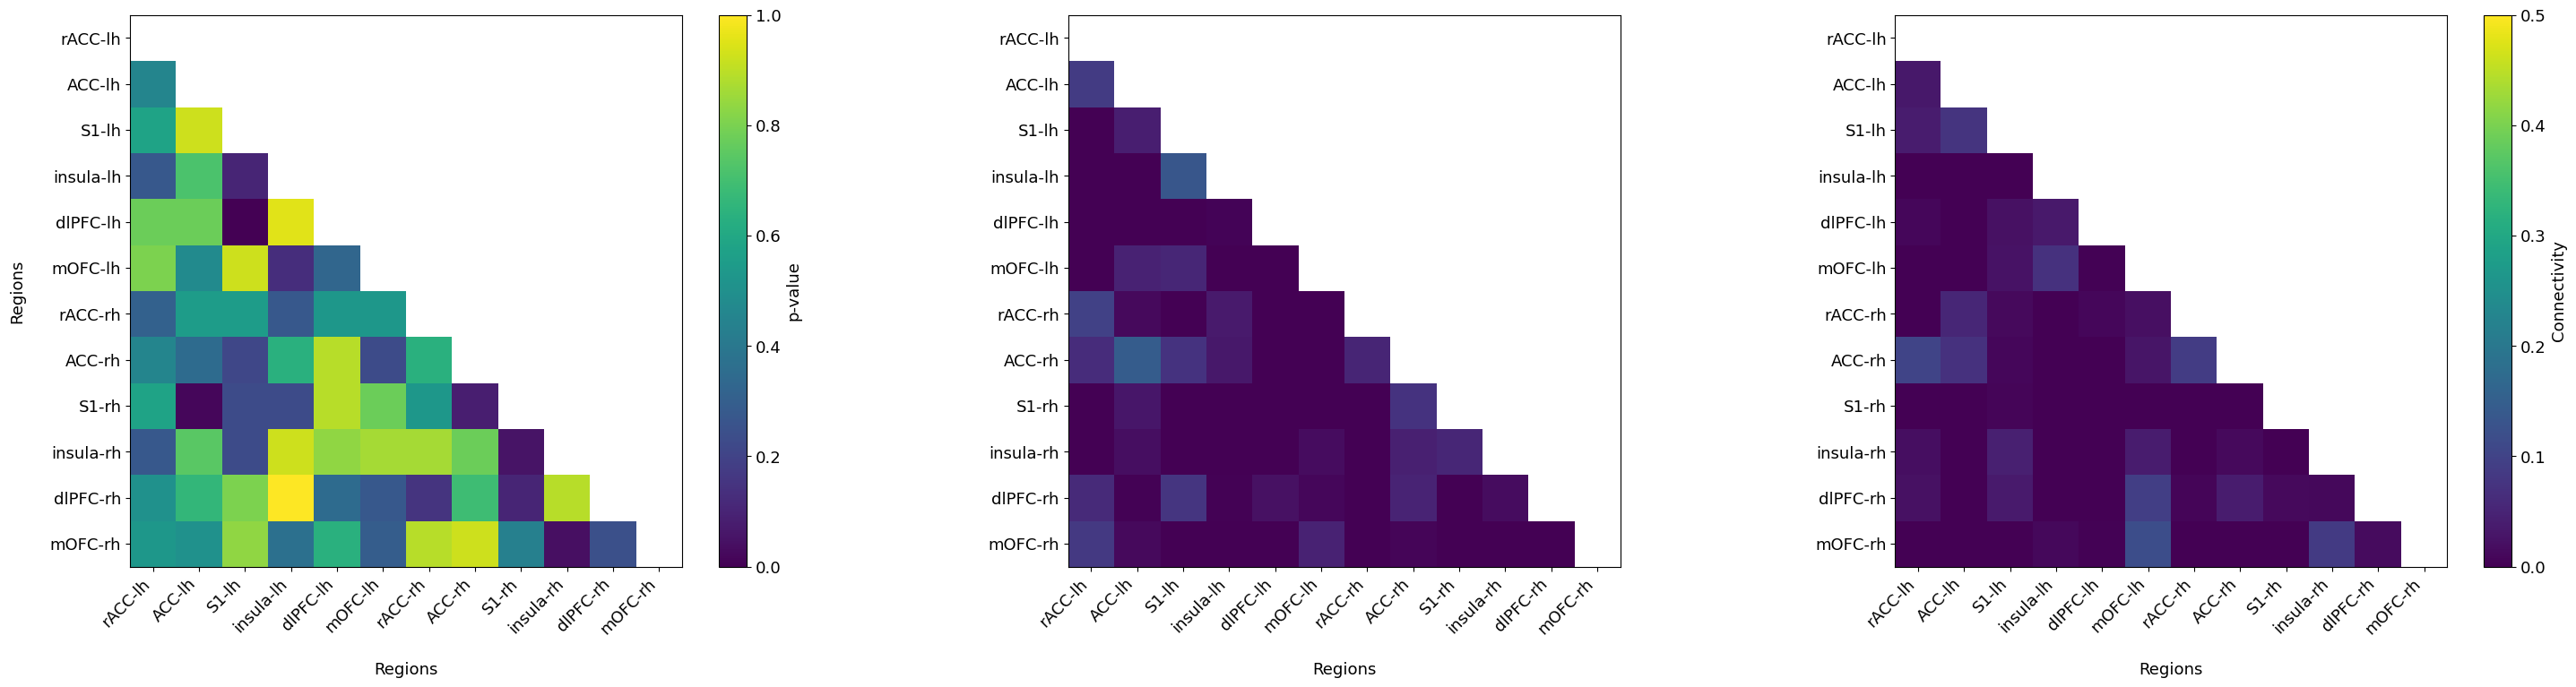

Hand 256 mN - CP w/ Widespread Pain vs. CP with Localized Pain - wpli2_debiased - alpha
Num epochs: 102 vs. 219
+--------------------+---------+----------------+----------------+
|      ROI Pair      | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+--------------------+---------+----------------+----------------+
| ACC-lh <-> rACC-lh |  0.049  |  0.142 ± 0.1   | -0.033 ± 0.041 |
+--------------------+---------+----------------+----------------+


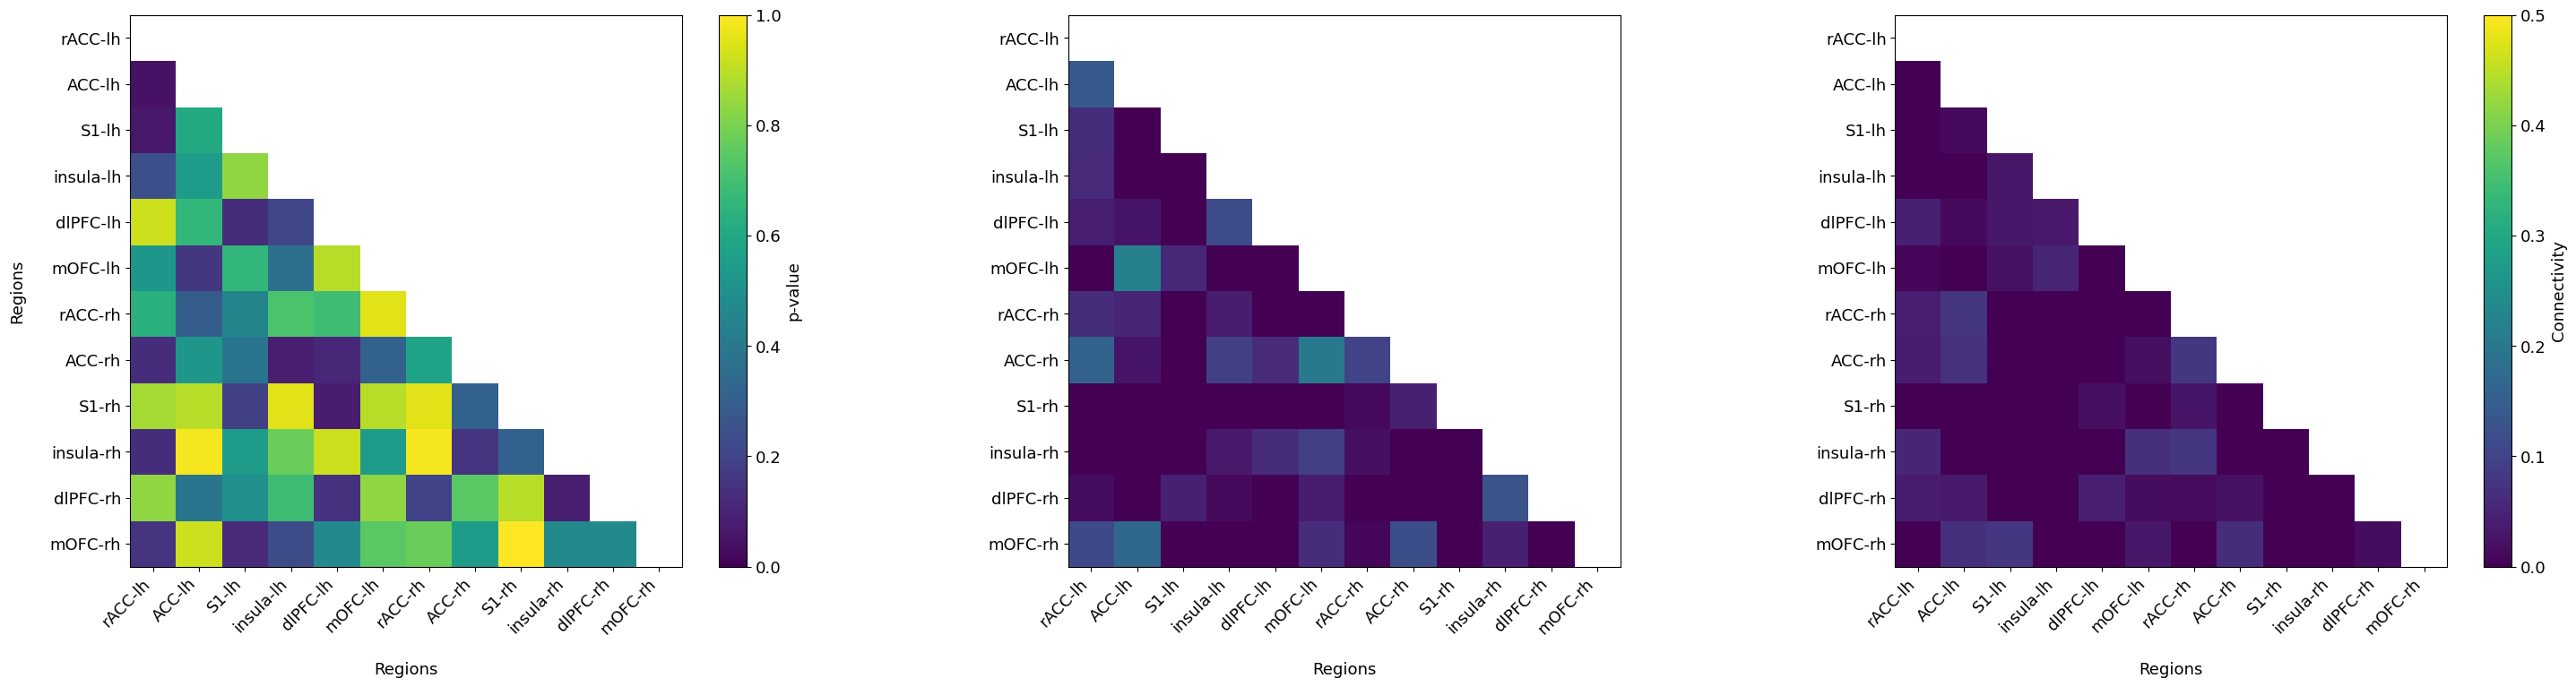

Hand 256 mN - CP w/ Widespread Pain vs. CP with Localized Pain - wpli2_debiased - low-gamma
Num epochs: 102 vs. 219
+--------------------+---------+----------------+----------------+
|      ROI Pair      | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+--------------------+---------+----------------+----------------+
| dlPFC-rh <-> S1-lh |  0.037  | 0.046 ± 0.033  | -0.029 ± 0.015 |
+--------------------+---------+----------------+----------------+


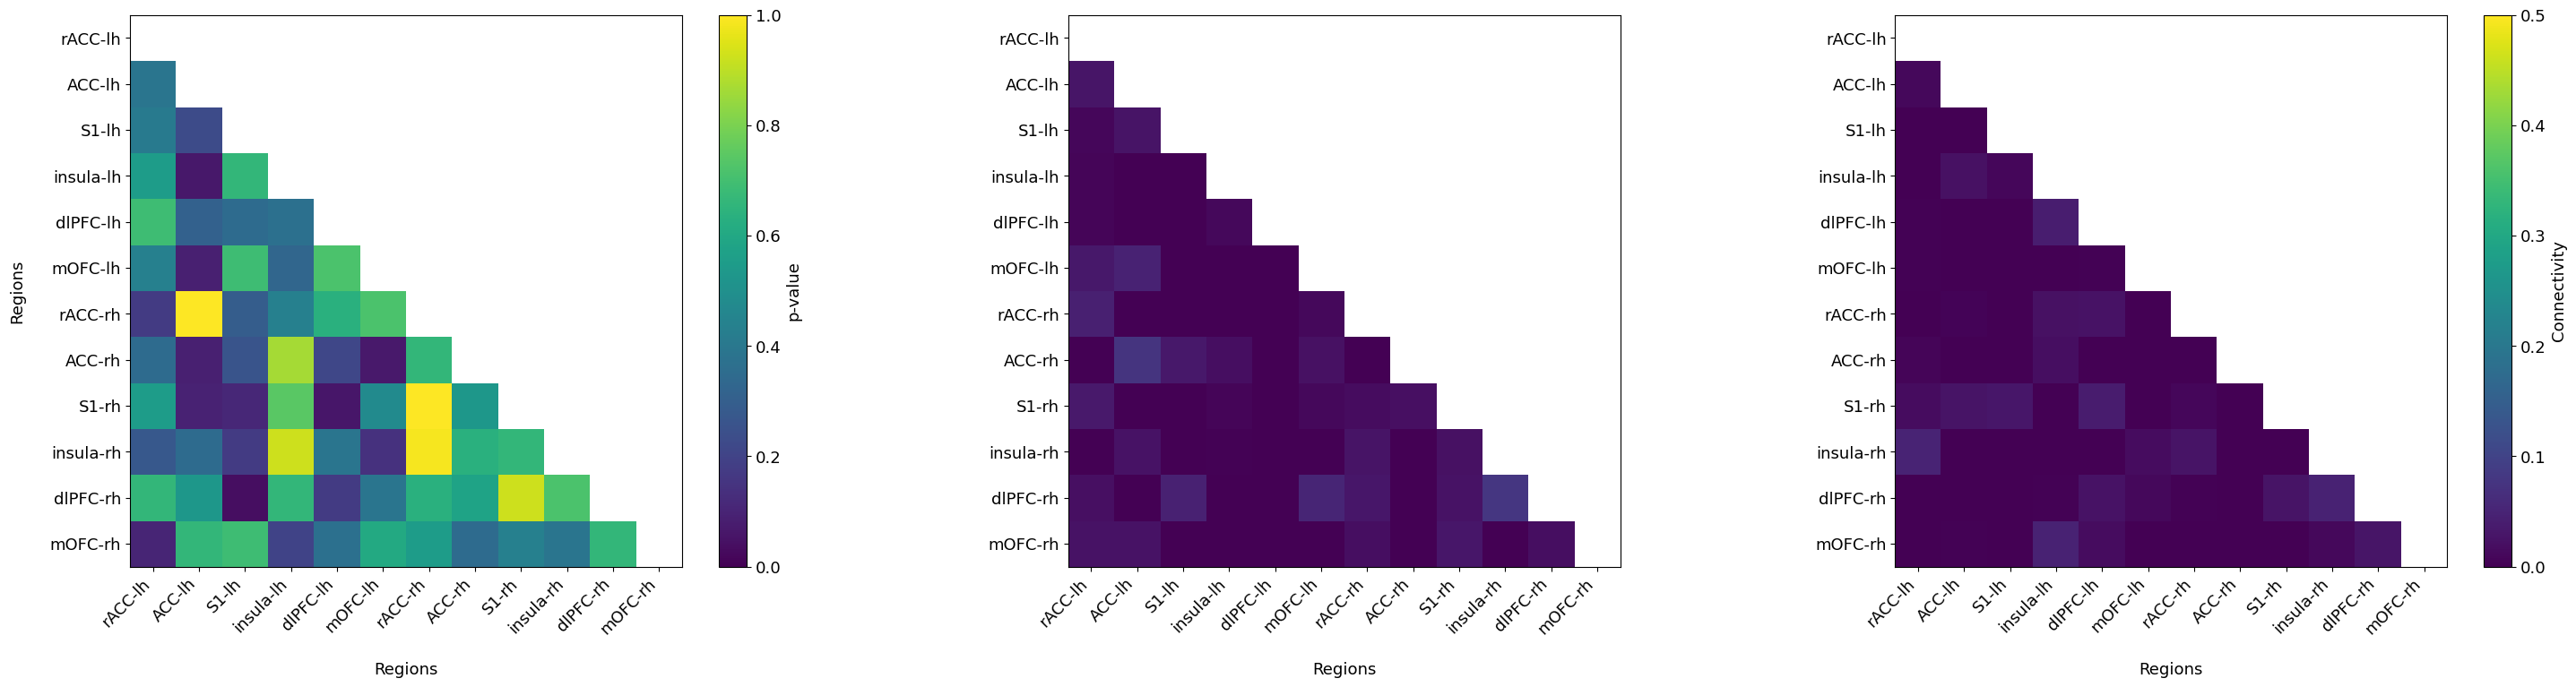

Hand 256 mN - CP w/ Widespread Pain vs. CP with Localized Pain - wpli2_debiased - high-gamma
Num epochs: 102 vs. 219
+----------+---------+----------------+----------------+
| ROI Pair | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+----------+---------+----------------+----------------+
+----------+---------+----------------+----------------+


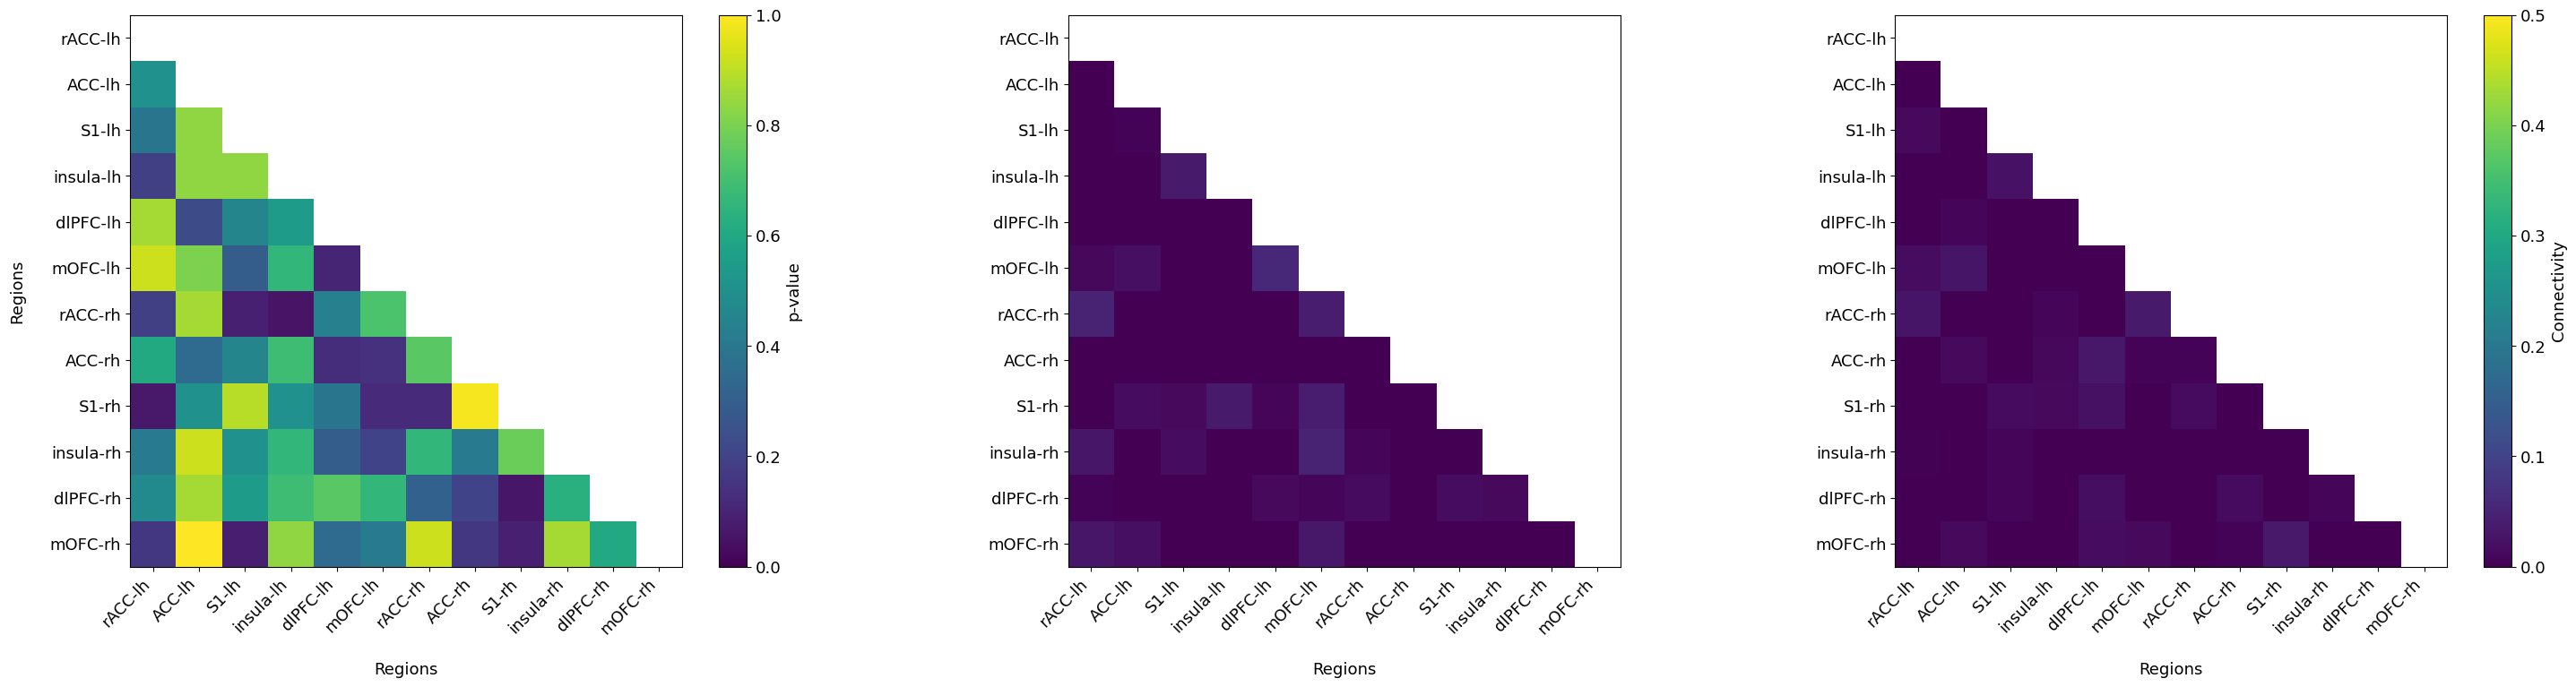

Hand 256 mN - CP w/ Widespread Pain vs. CP with Localized Pain - aec_pairwise - theta
Num epochs: 102 vs. 219
+--------------------+---------+----------------+----------------+
|      ROI Pair      | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+--------------------+---------+----------------+----------------+
| S1-lh <-> rACC-lh  |  0.045  | 0.284 ± 0.012  |  0.249 ± 0.01  |
|  S1-lh <-> ACC-lh  |  0.034  | 0.291 ± 0.018  | 0.251 ± 0.008  |
| dlPFC-rh <-> S1-rh |  0.045  | 0.269 ± 0.019  | 0.233 ± 0.008  |
+--------------------+---------+----------------+----------------+


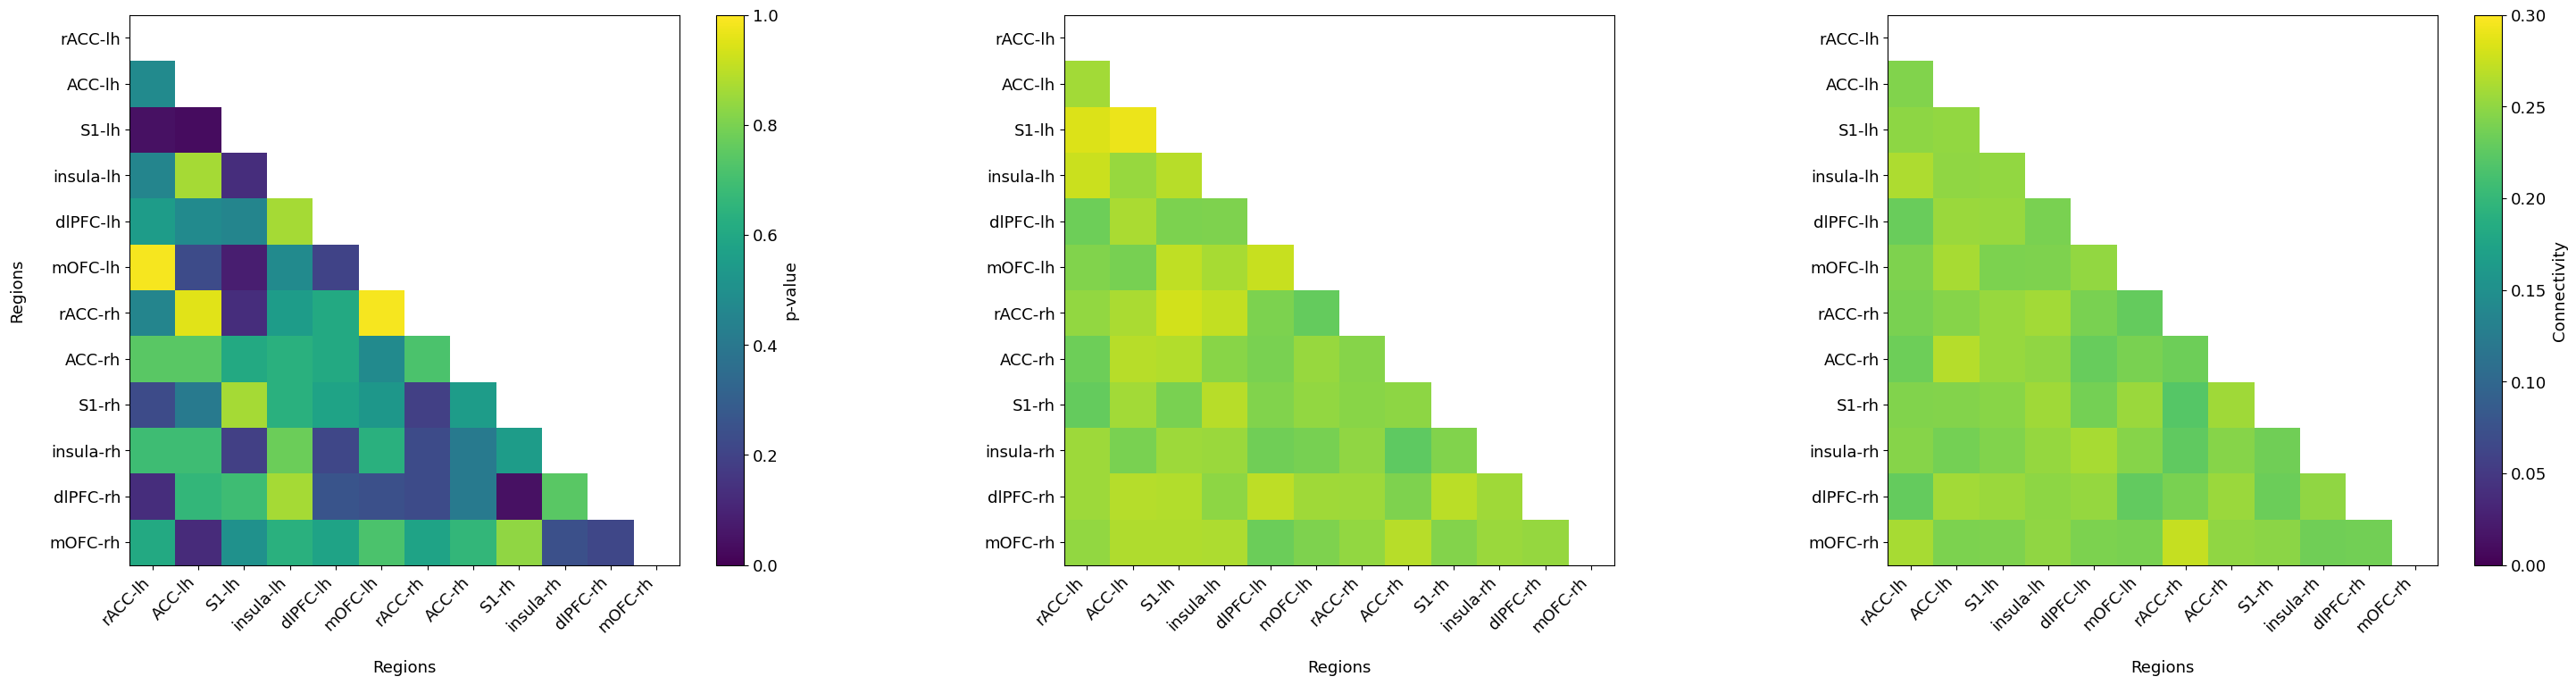

Hand 256 mN - CP w/ Widespread Pain vs. CP with Localized Pain - aec_pairwise - alpha
Num epochs: 102 vs. 219
+------------------------+---------+----------------+----------------+
|        ROI Pair        | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+------------------------+---------+----------------+----------------+
| insula-rh <-> dlPFC-lh |  0.041  | 0.245 ± 0.012  | 0.216 ± 0.008  |
|  dlPFC-rh <-> rACC-rh  |  0.025  |  0.187 ± 0.01  | 0.228 ± 0.011  |
+------------------------+---------+----------------+----------------+


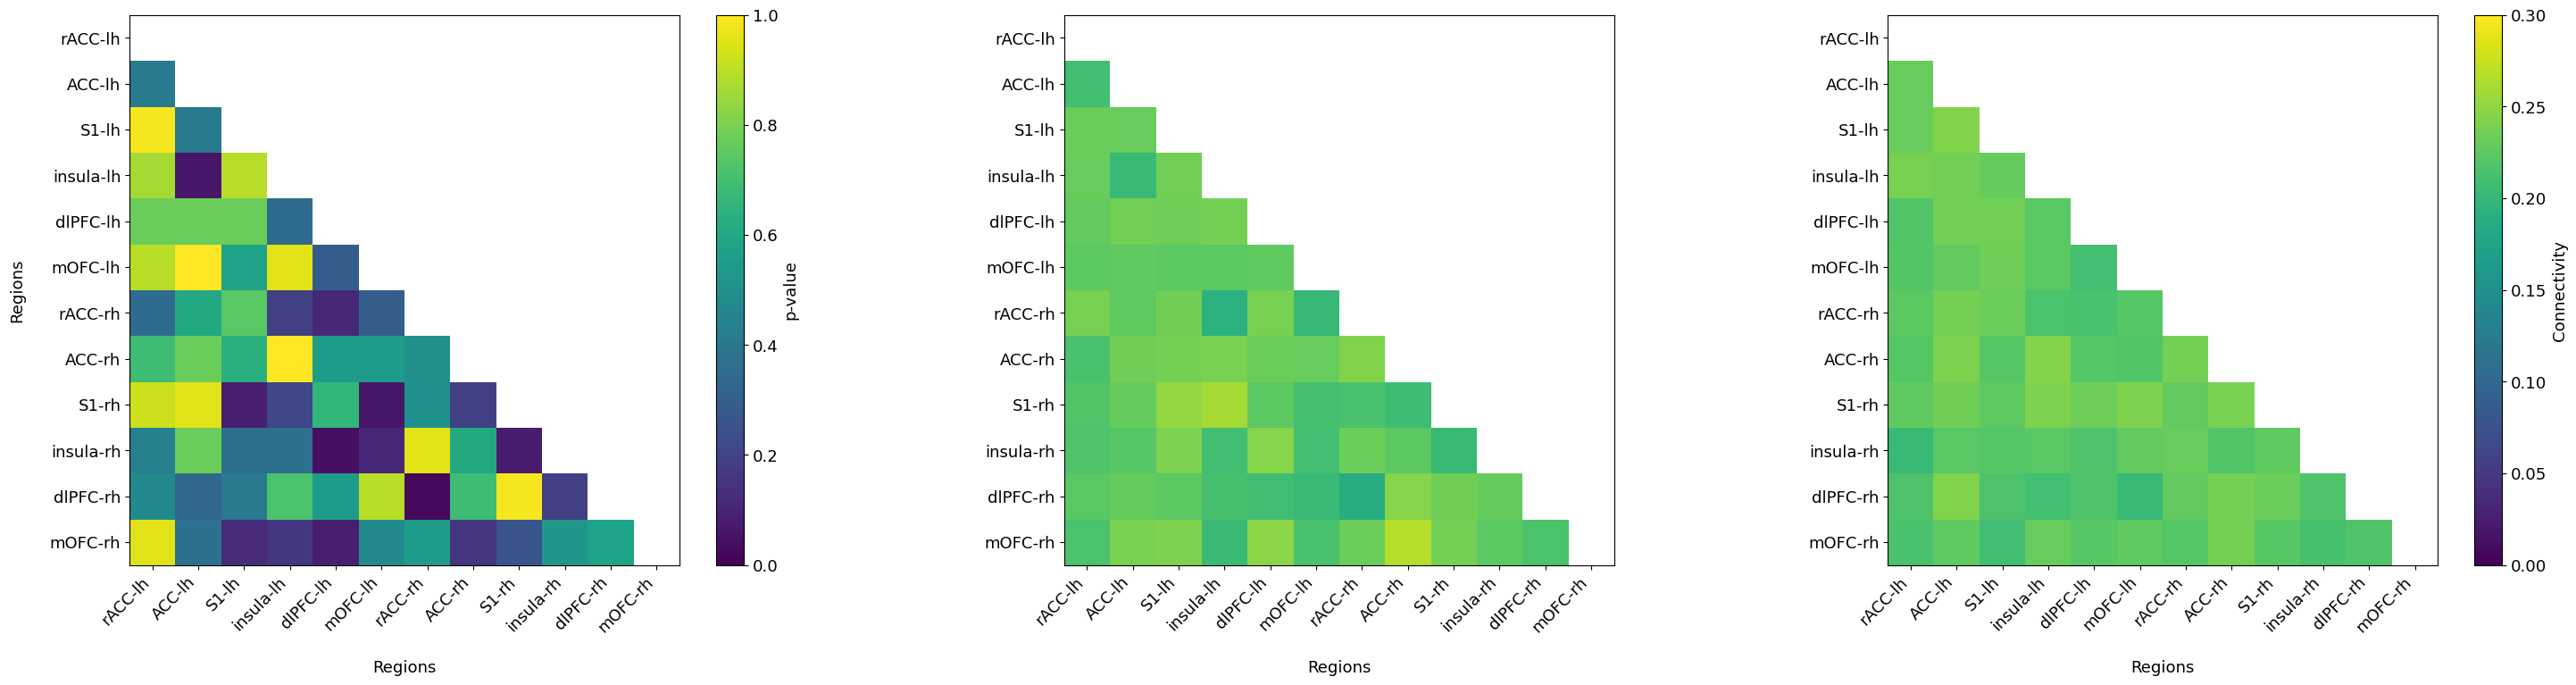

Hand 256 mN - CP w/ Widespread Pain vs. CP with Localized Pain - aec_pairwise - low-gamma
Num epochs: 102 vs. 219
+---------------------+---------+----------------+----------------+
|      ROI Pair       | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+---------------------+---------+----------------+----------------+
| dlPFC-lh <-> ACC-lh |  0.021  | 0.093 ± 0.004  |  0.11 ± 0.004  |
|  S1-rh <-> rACC-rh  |  0.031  | 0.092 ± 0.008  | 0.114 ± 0.005  |
|  S1-rh <-> ACC-rh   |  0.009  | 0.089 ± 0.006  | 0.108 ± 0.003  |
+---------------------+---------+----------------+----------------+


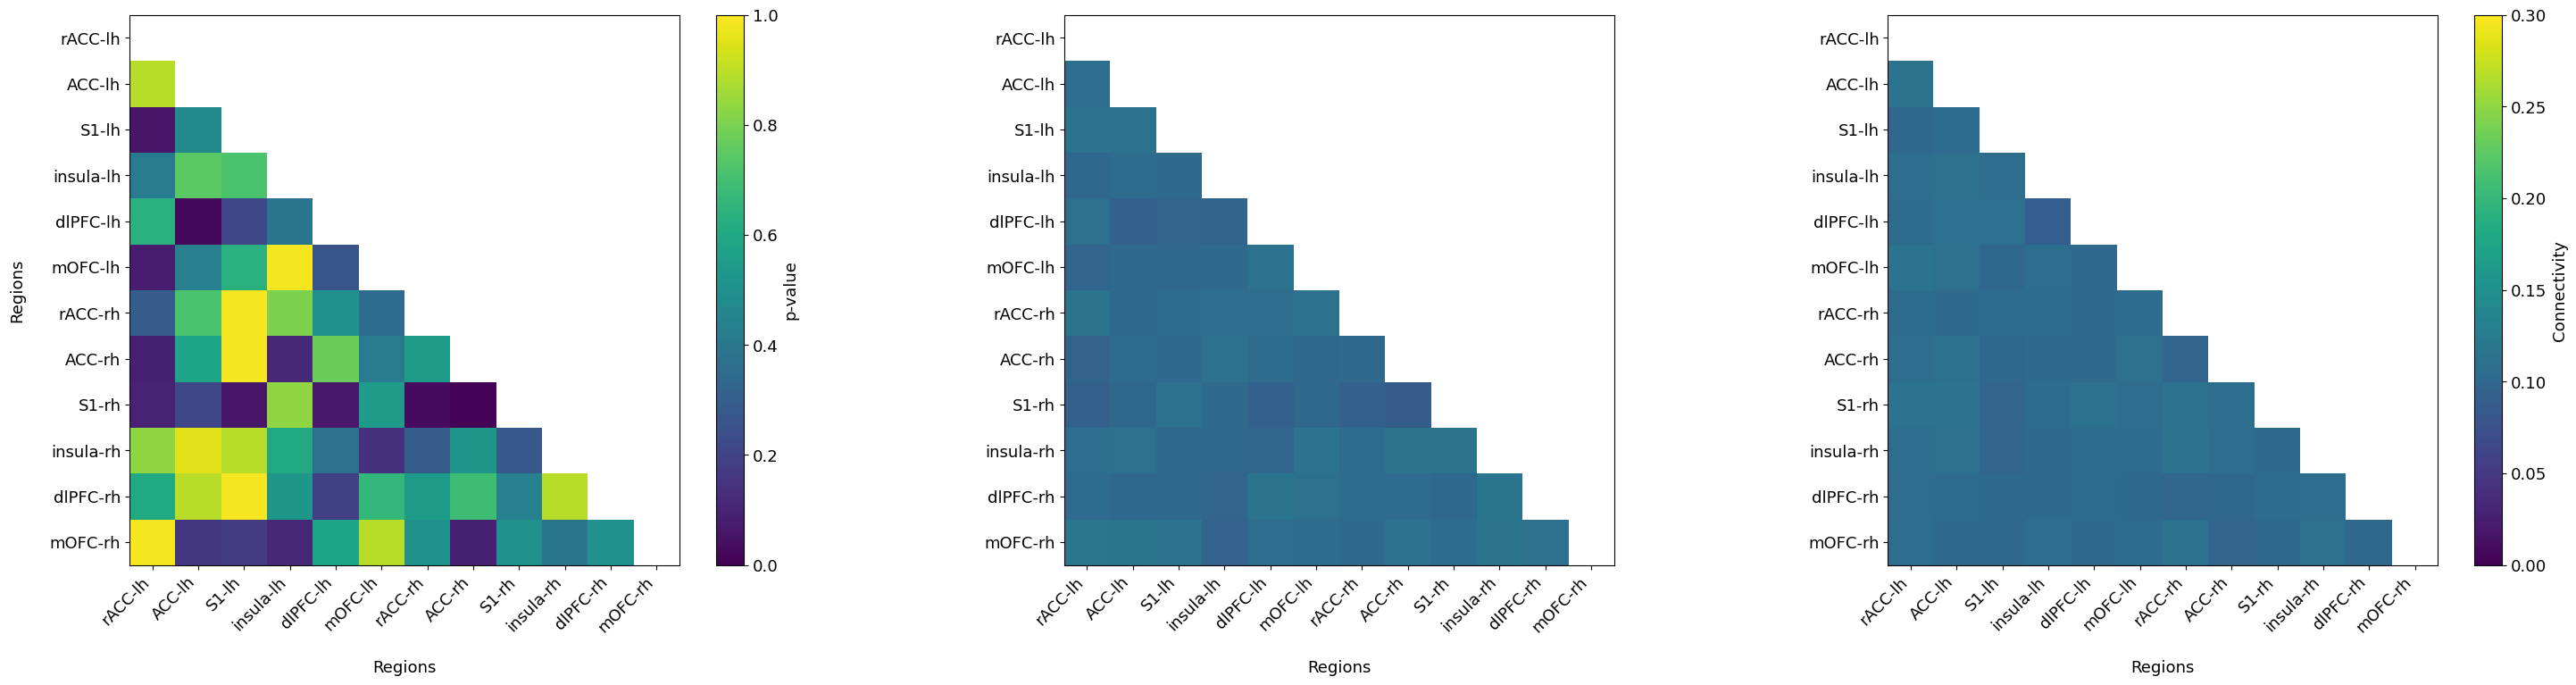

Hand 256 mN - CP w/ Widespread Pain vs. CP with Localized Pain - aec_pairwise - high-gamma
Num epochs: 102 vs. 219
+----------------------+---------+----------------+----------------+
|       ROI Pair       | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+----------------------+---------+----------------+----------------+
|  dlPFC-lh <-> S1-lh  |  0.021  | 0.101 ± 0.008  |  0.08 ± 0.005  |
|  rACC-rh <-> S1-lh   |  0.019  | 0.075 ± 0.006  | 0.094 ± 0.004  |
|  ACC-rh <-> rACC-lh  |  0.049  | 0.078 ± 0.004  | 0.094 ± 0.006  |
| insula-rh <-> ACC-rh |  0.037  | 0.073 ± 0.004  | 0.089 ± 0.004  |
| mOFC-rh <-> rACC-rh  |  0.008  | 0.083 ± 0.005  | 0.099 ± 0.004  |
+----------------------+---------+----------------+----------------+


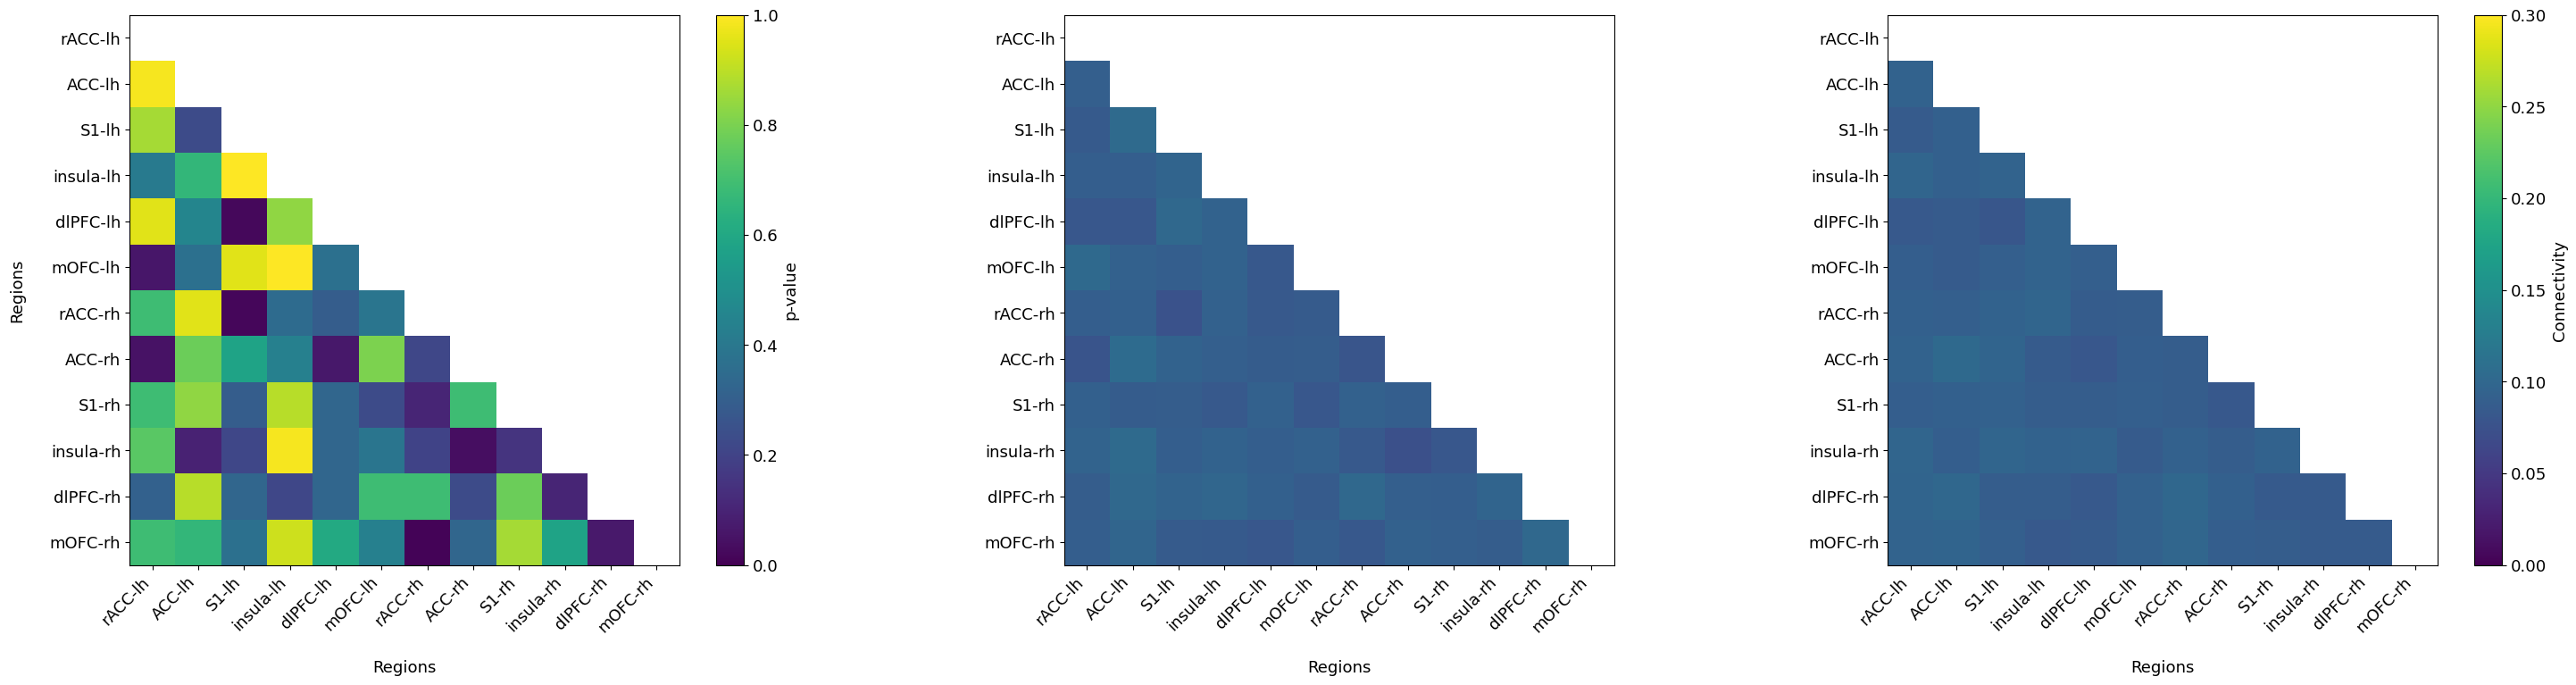

Hand 256 mN - CP w/ Widespread Pain vs. CP with Localized Pain - aec_symmetric - theta
Num epochs: 102 vs. 219
+---------------------+---------+----------------+----------------+
|      ROI Pair       | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+---------------------+---------+----------------+----------------+
|  S1-lh <-> ACC-lh   |  0.028  | 0.083 ± 0.023  | 0.137 ± 0.012  |
| mOFC-rh <-> rACC-rh |  0.041  | 0.113 ± 0.031  | 0.185 ± 0.021  |
+---------------------+---------+----------------+----------------+


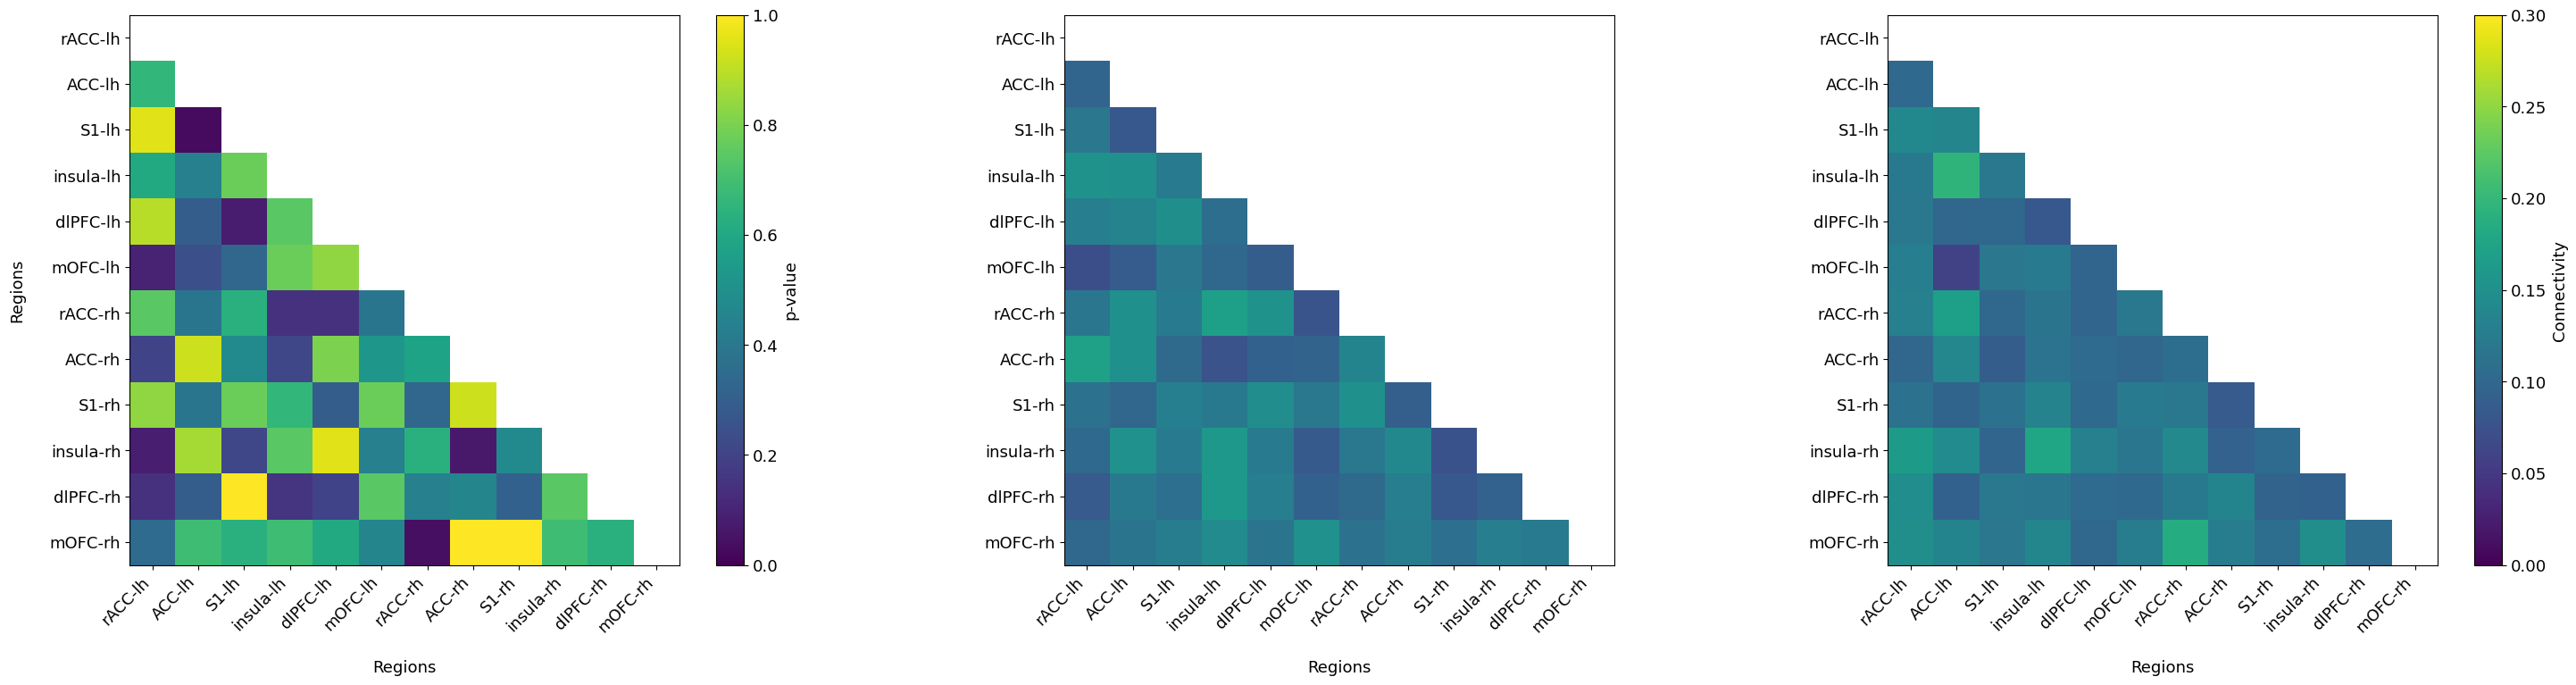

Hand 256 mN - CP w/ Widespread Pain vs. CP with Localized Pain - aec_symmetric - alpha
Num epochs: 102 vs. 219
+-----------------------+---------+----------------+----------------+
|       ROI Pair        | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+-----------------------+---------+----------------+----------------+
|  ACC-lh <-> rACC-lh   |  0.028  | 0.046 ± 0.013  |  0.111 ± 0.02  |
| insula-lh <-> rACC-lh |  0.049  |  0.14 ± 0.021  | 0.092 ± 0.015  |
|  mOFC-lh <-> ACC-lh   |  0.041  |  0.07 ± 0.017  | 0.126 ± 0.017  |
+-----------------------+---------+----------------+----------------+


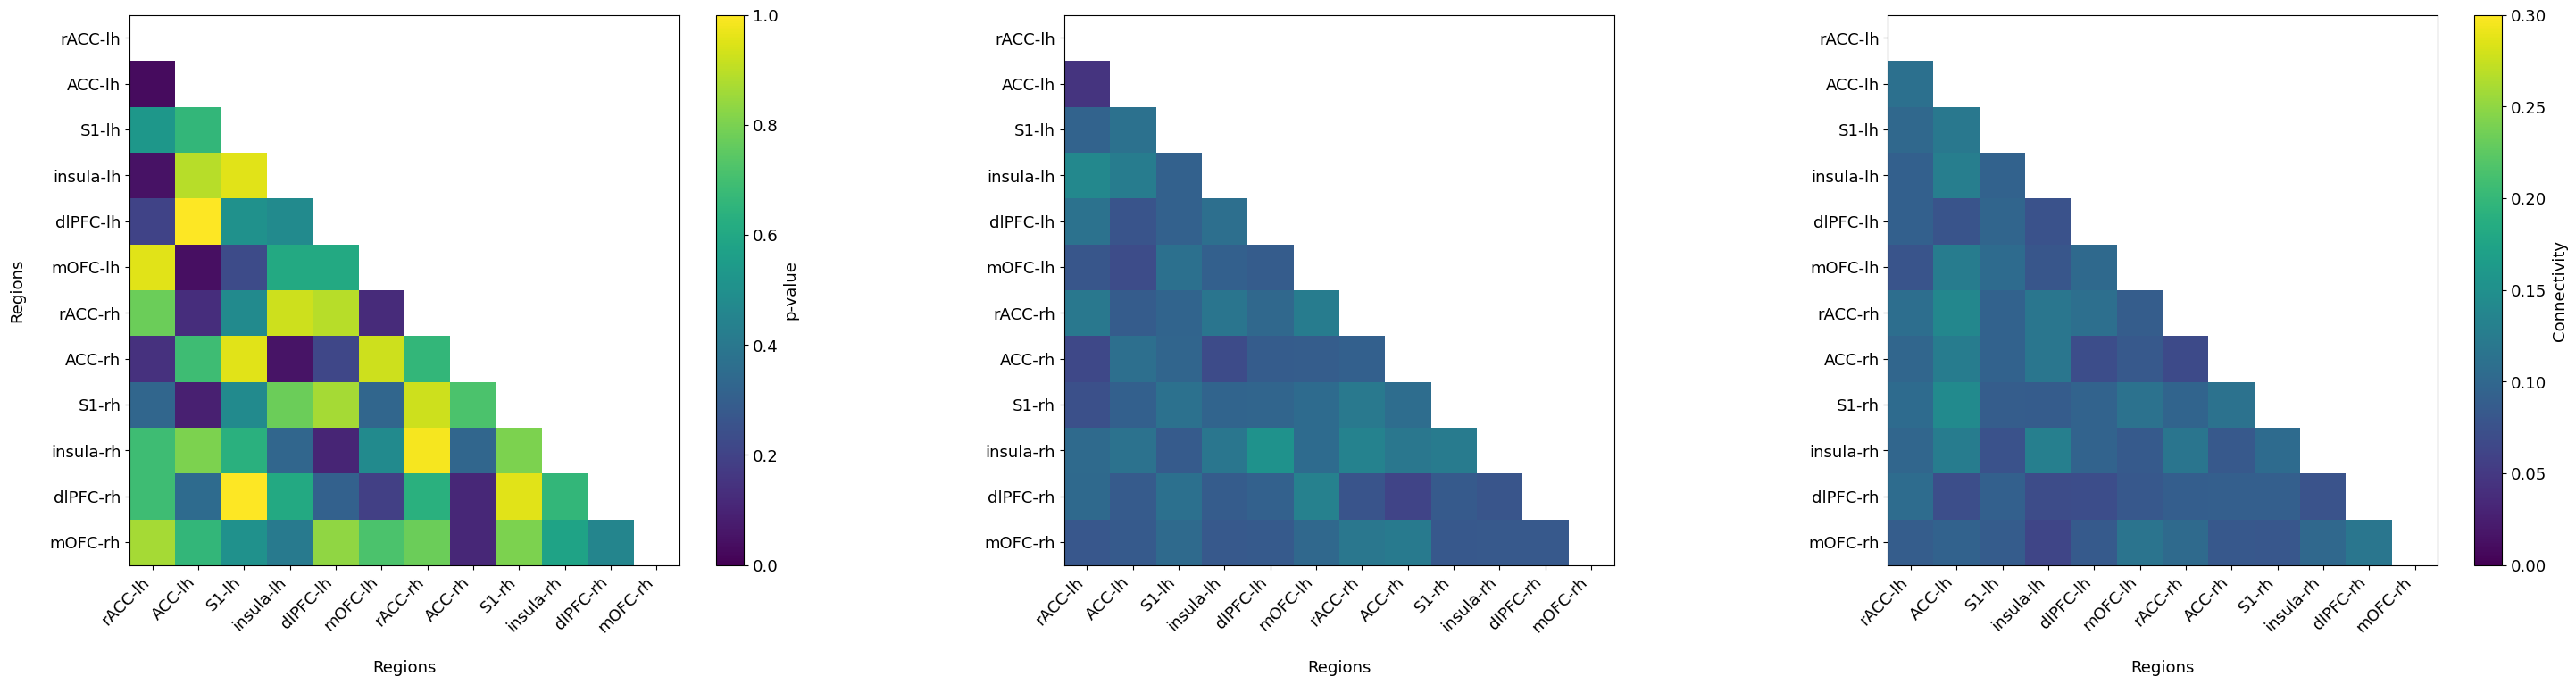

Hand 256 mN - CP w/ Widespread Pain vs. CP with Localized Pain - aec_symmetric - low-gamma
Num epochs: 102 vs. 219
+----------------------+---------+----------------+----------------+
|       ROI Pair       | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+----------------------+---------+----------------+----------------+
|  S1-lh <-> rACC-lh   |  0.045  |  0.05 ± 0.008  | 0.031 ± 0.005  |
|   ACC-rh <-> S1-lh   |  0.011  |  0.056 ± 0.01  | 0.024 ± 0.004  |
| mOFC-rh <-> rACC-lh  |  0.017  | 0.078 ± 0.011  | 0.042 ± 0.007  |
| mOFC-rh <-> dlPFC-lh |  0.025  | 0.024 ± 0.009  | 0.068 ± 0.011  |
|  mOFC-rh <-> ACC-rh  |  0.049  | 0.032 ± 0.007  | 0.055 ± 0.007  |
+----------------------+---------+----------------+----------------+


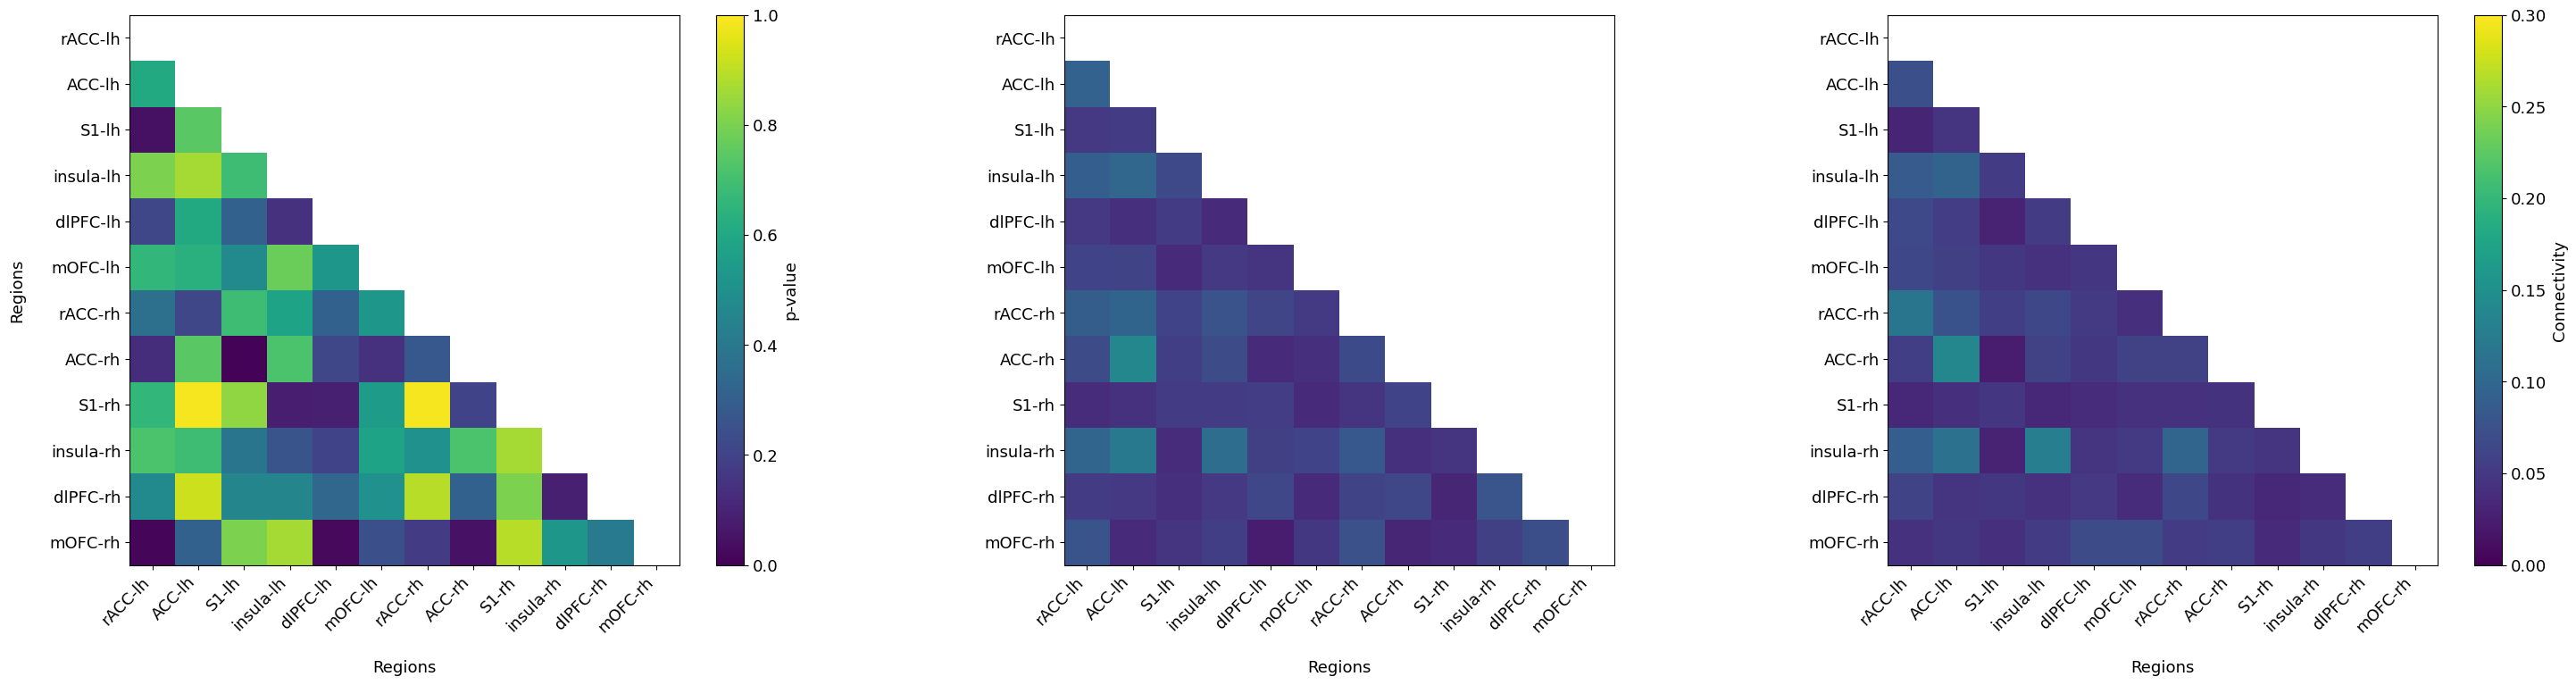

Hand 256 mN - CP w/ Widespread Pain vs. CP with Localized Pain - aec_symmetric - high-gamma
Num epochs: 102 vs. 219
+-----------------------+---------+----------------+----------------+
|       ROI Pair        | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+-----------------------+---------+----------------+----------------+
| insula-lh <-> rACC-lh |  0.025  |  0.119 ± 0.01  | 0.088 ± 0.009  |
|   mOFC-lh <-> S1-lh   |  0.023  | 0.031 ± 0.009  | 0.055 ± 0.006  |
|   S1-rh <-> ACC-lh    |  0.023  | 0.056 ± 0.008  | 0.034 ± 0.007  |
|  mOFC-rh <-> mOFC-lh  |  0.008  | 0.049 ± 0.012  | 0.087 ± 0.009  |
|  mOFC-rh <-> rACC-rh  |  0.045  | 0.088 ± 0.015  | 0.056 ± 0.008  |
| mOFC-rh <-> insula-rh |  0.014  | 0.086 ± 0.013  | 0.045 ± 0.007  |
+-----------------------+---------+----------------+----------------+


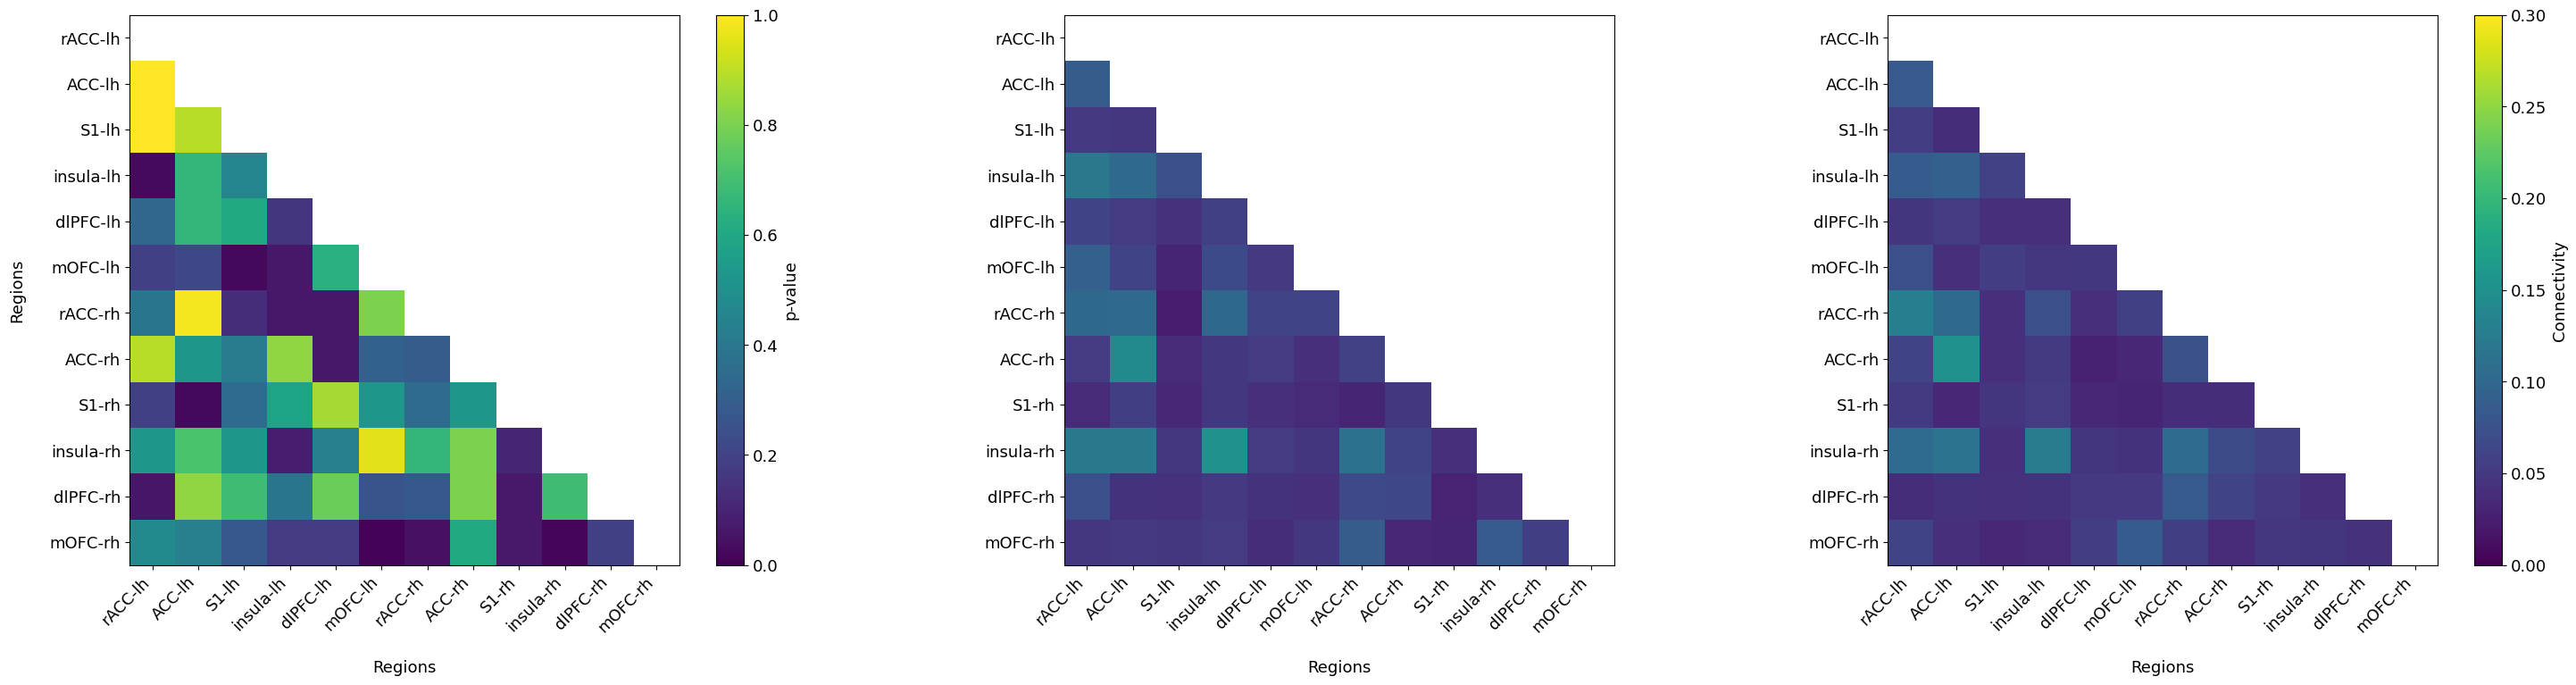

Eyes Open - CP w/ Widespread Pain vs. CP with Localized Pain - wpli2_debiased - theta
Num epochs: 100 vs. 211
+-----------------------+---------+----------------+----------------+
|       ROI Pair        | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+-----------------------+---------+----------------+----------------+
| insula-lh <-> rACC-lh |  0.027  | 0.143 ± 0.061  | -0.03 ± 0.046  |
|   S1-rh <-> ACC-lh    |  0.043  | 0.127 ± 0.076  | -0.025 ± 0.042 |
+-----------------------+---------+----------------+----------------+


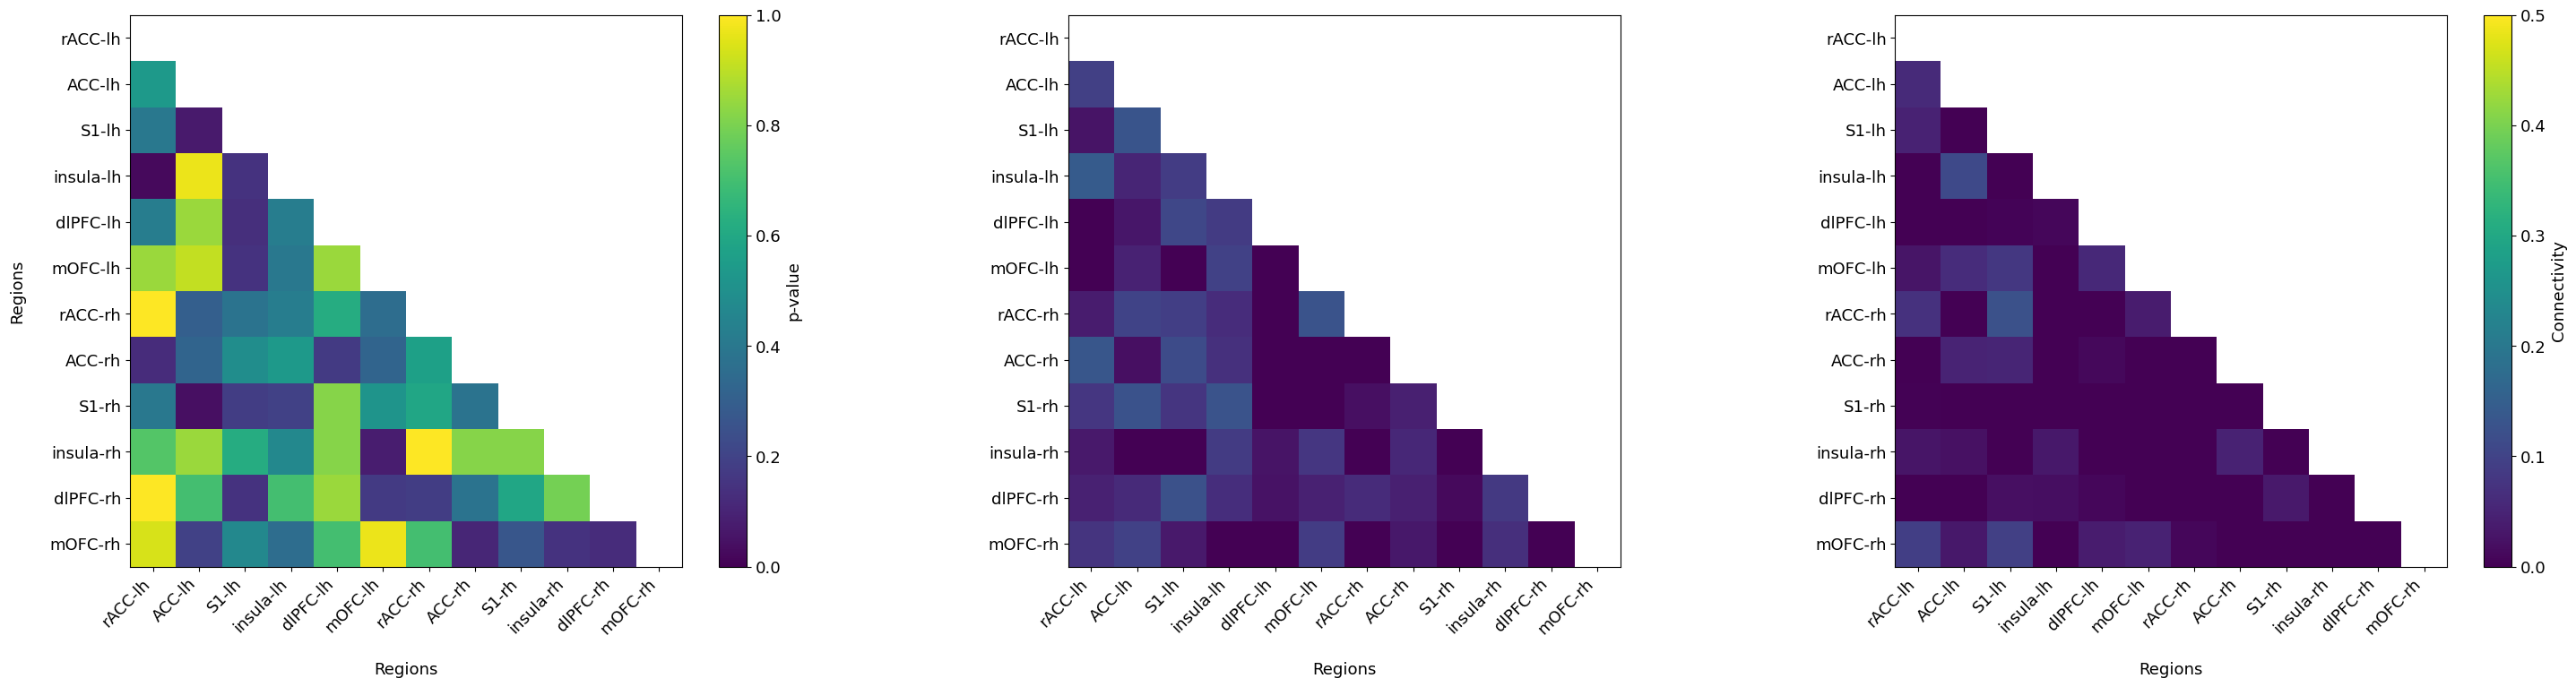

Eyes Open - CP w/ Widespread Pain vs. CP with Localized Pain - wpli2_debiased - alpha
Num epochs: 100 vs. 211
+-----------------------+---------+----------------+----------------+
|       ROI Pair        | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+-----------------------+---------+----------------+----------------+
| insula-lh <-> rACC-lh |  0.029  | 0.163 ± 0.066  | -0.037 ± 0.049 |
| insula-lh <-> ACC-lh  |  0.007  | 0.167 ± 0.077  | -0.075 ± 0.027 |
|  mOFC-rh <-> ACC-lh   |  0.016  | 0.218 ± 0.109  | -0.039 ± 0.048 |
+-----------------------+---------+----------------+----------------+


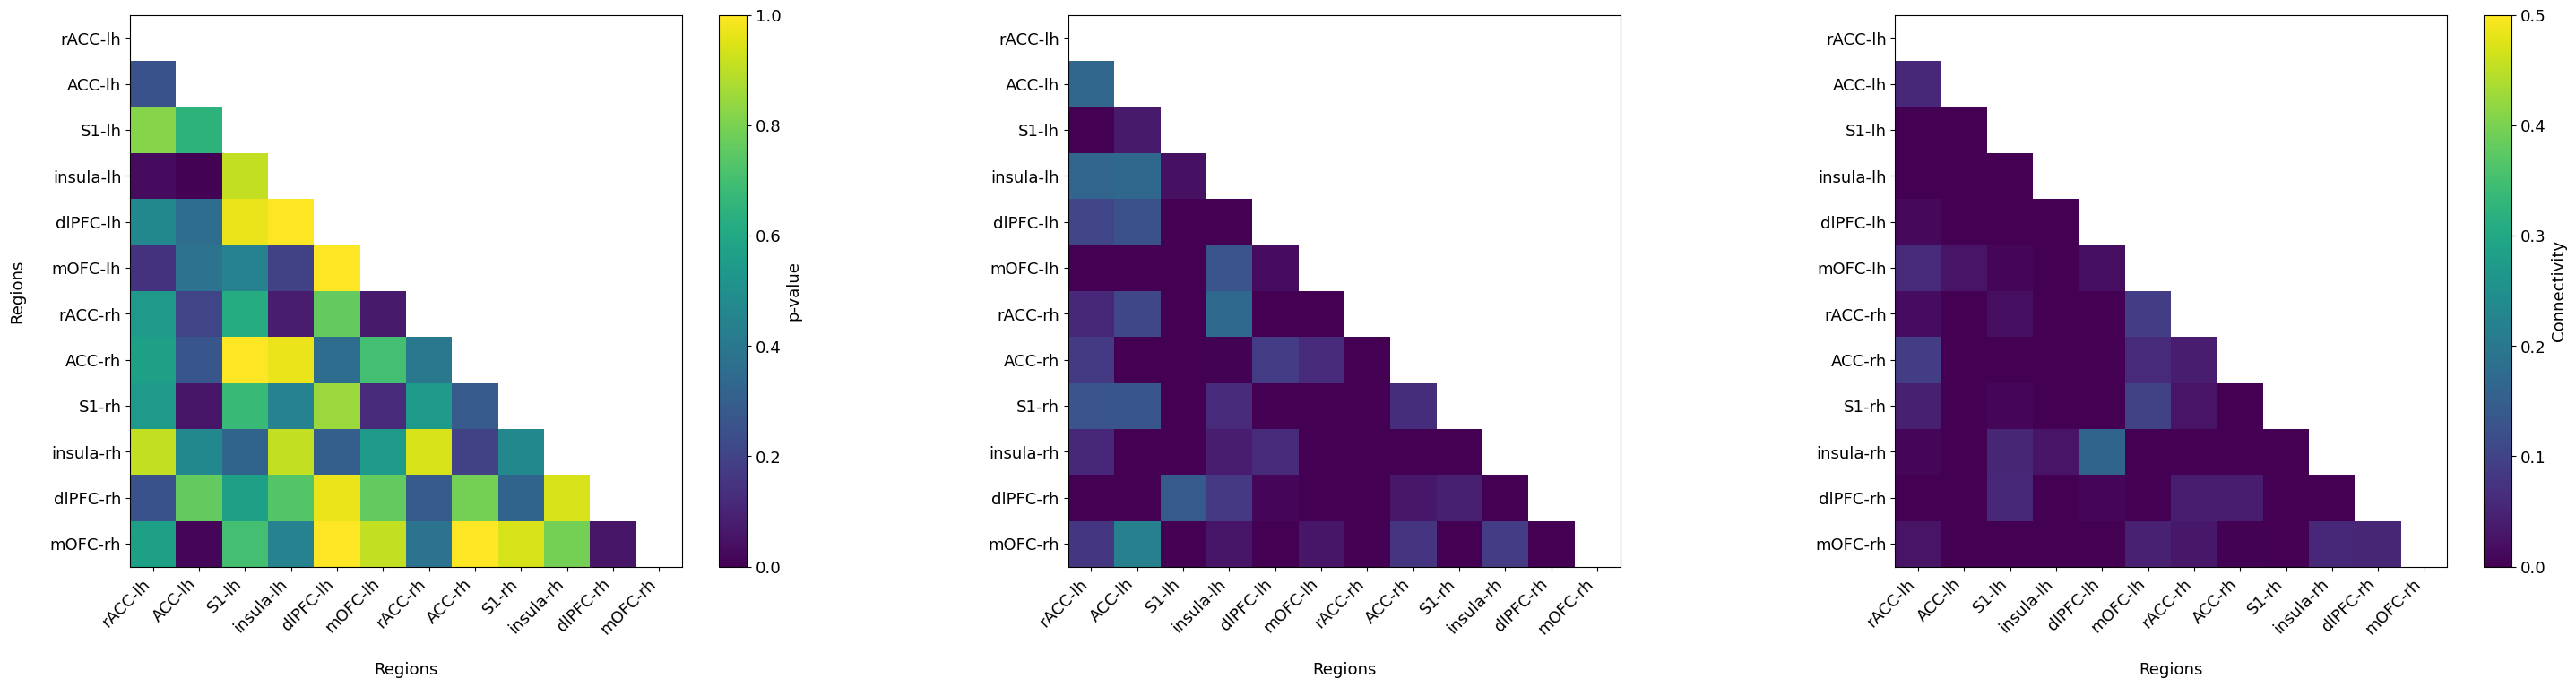

Eyes Open - CP w/ Widespread Pain vs. CP with Localized Pain - wpli2_debiased - low-gamma
Num epochs: 100 vs. 211
+--------------------+---------+----------------+----------------+
|      ROI Pair      | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+--------------------+---------+----------------+----------------+
| ACC-rh <-> rACC-rh |  0.001  | -0.075 ± 0.016 |  0.07 ± 0.035  |
| mOFC-rh <-> S1-lh  |  0.02   | -0.084 ± 0.018 | -0.011 ± 0.021 |
+--------------------+---------+----------------+----------------+


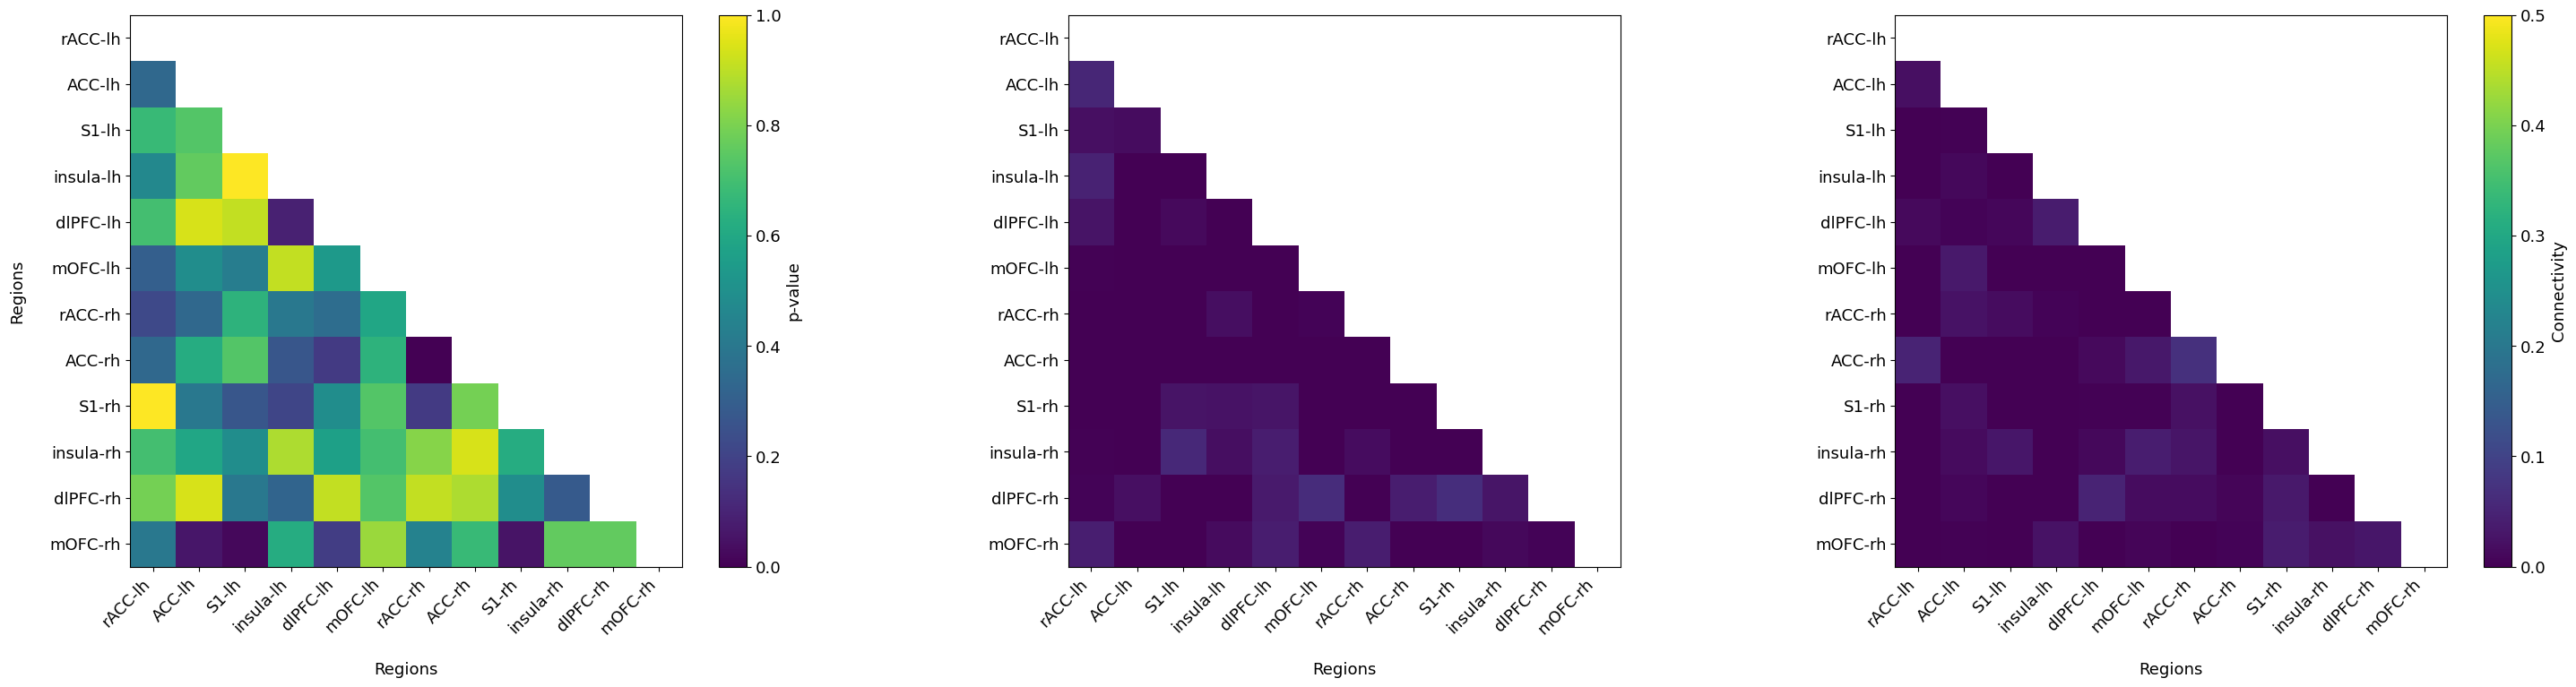

Eyes Open - CP w/ Widespread Pain vs. CP with Localized Pain - wpli2_debiased - high-gamma
Num epochs: 100 vs. 211
+-----------------------+---------+----------------+----------------+
|       ROI Pair        | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+-----------------------+---------+----------------+----------------+
| insula-lh <-> rACC-lh |  0.02   | -0.066 ± 0.027 | 0.016 ± 0.021  |
| ACC-rh <-> insula-lh  |  0.005  | -0.047 ± 0.034 | 0.011 ± 0.022  |
+-----------------------+---------+----------------+----------------+


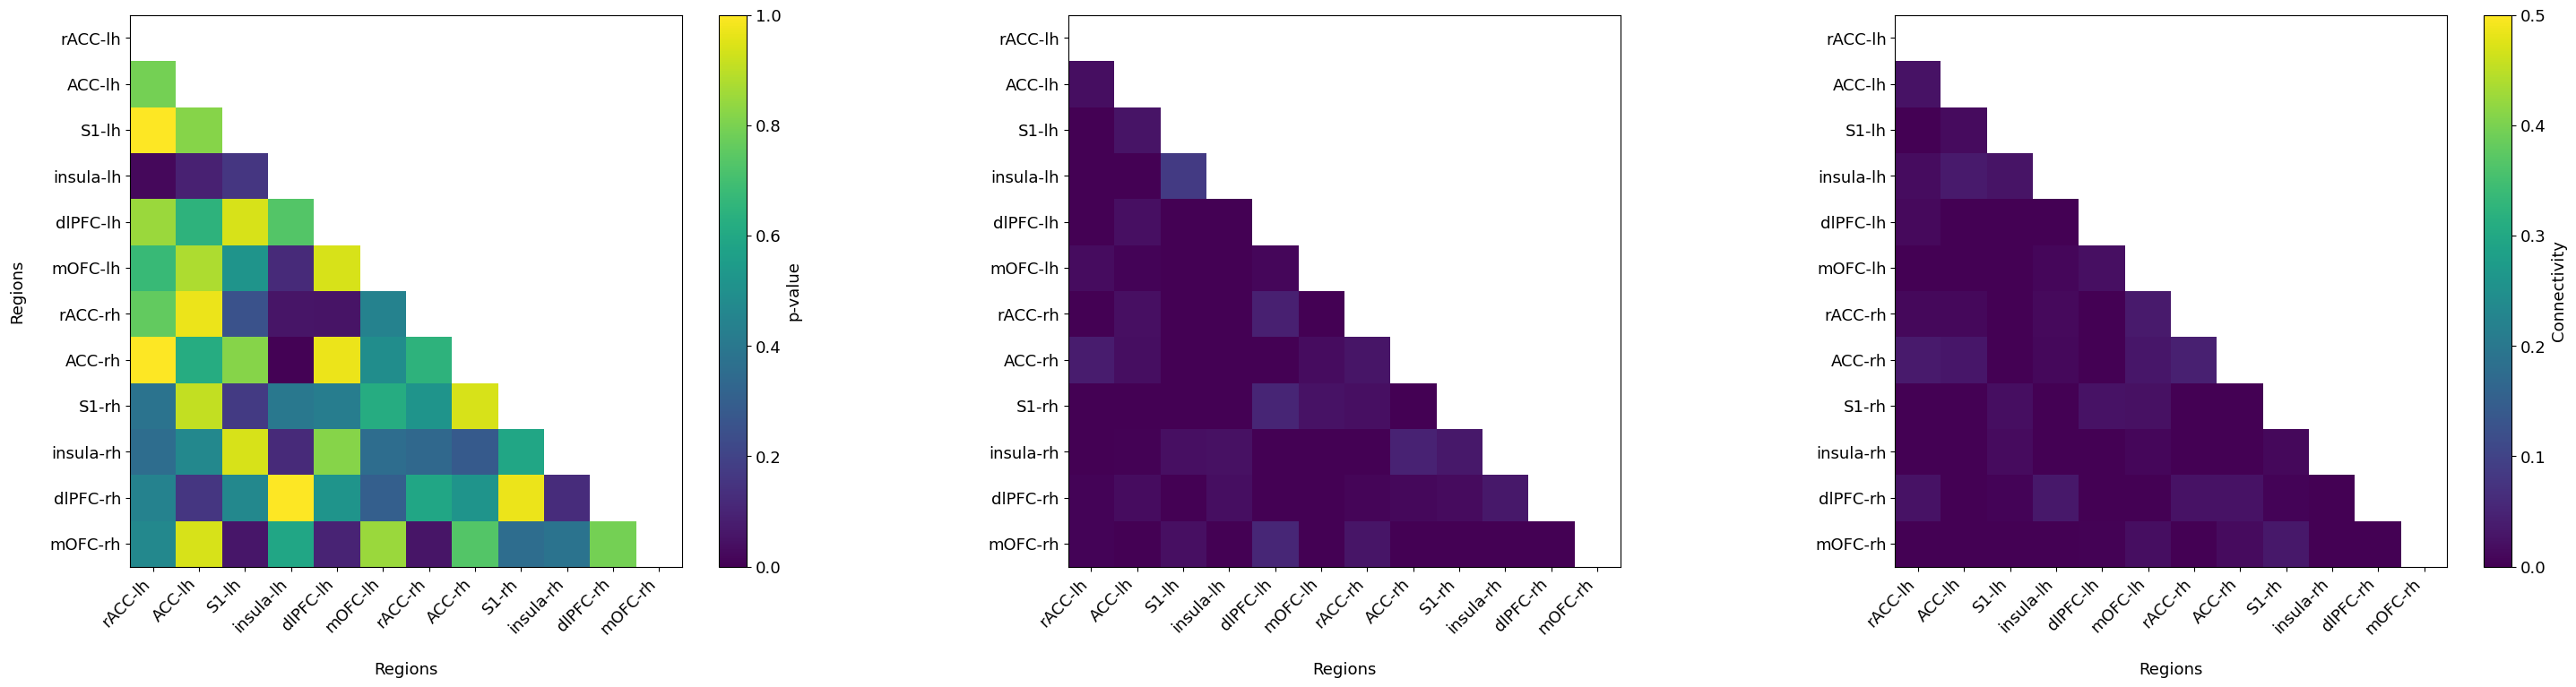

Eyes Open - CP w/ Widespread Pain vs. CP with Localized Pain - aec_pairwise - theta
Num epochs: 100 vs. 211
+-----------------------+---------+----------------+----------------+
|       ROI Pair        | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+-----------------------+---------+----------------+----------------+
| insula-lh <-> rACC-lh |  0.032  | 0.231 ± 0.013  | 0.273 ± 0.013  |
+-----------------------+---------+----------------+----------------+


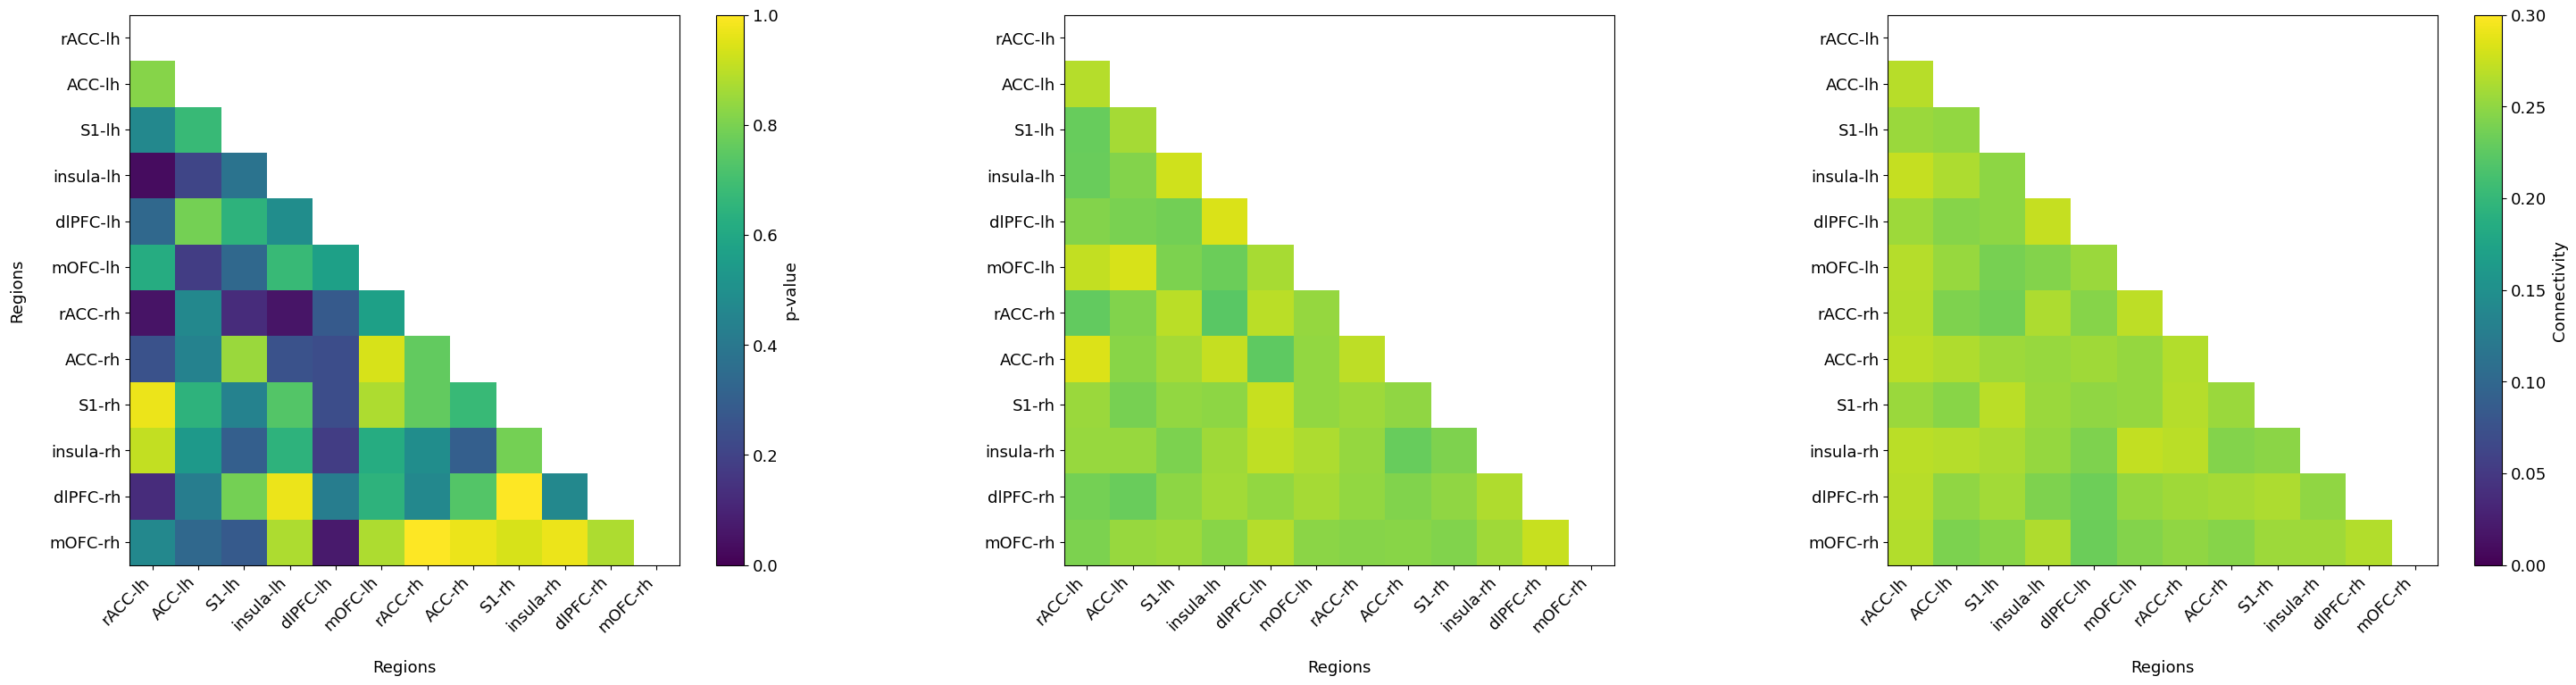

Eyes Open - CP w/ Widespread Pain vs. CP with Localized Pain - aec_pairwise - alpha
Num epochs: 100 vs. 211
+----------+---------+----------------+----------------+
| ROI Pair | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+----------+---------+----------------+----------------+
+----------+---------+----------------+----------------+


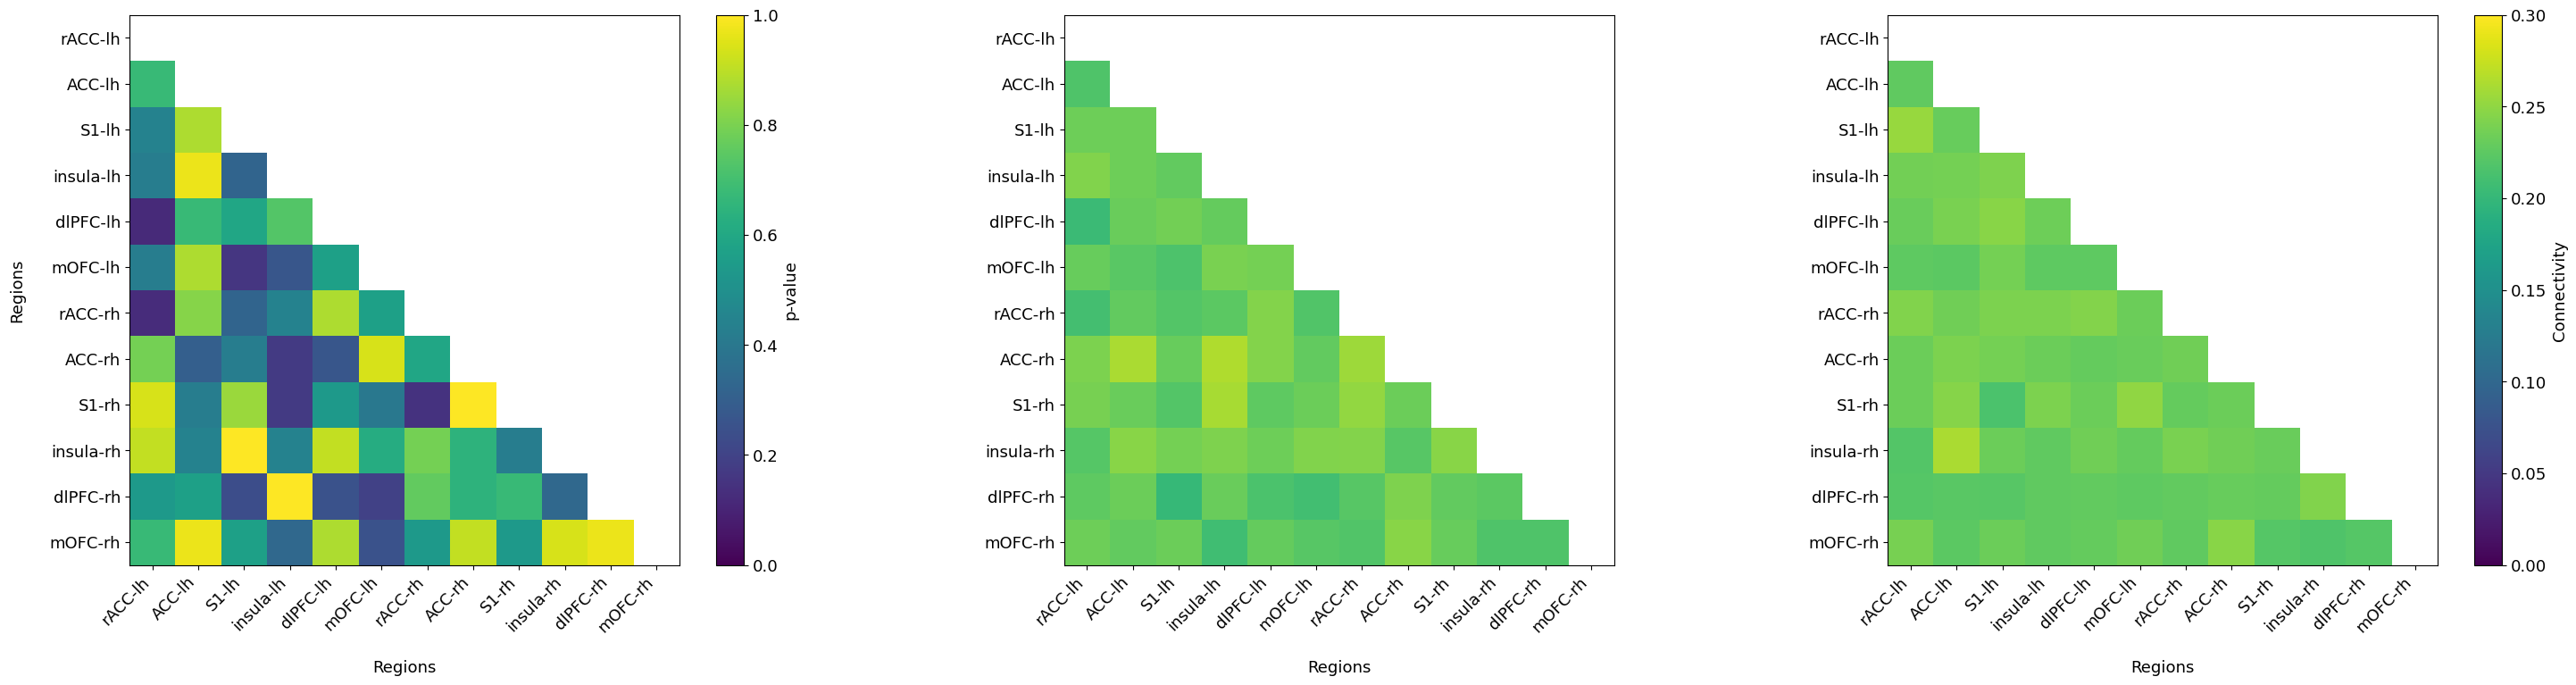

Eyes Open - CP w/ Widespread Pain vs. CP with Localized Pain - aec_pairwise - low-gamma
Num epochs: 100 vs. 211
+---------------------+---------+----------------+----------------+
|      ROI Pair       | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+---------------------+---------+----------------+----------------+
| mOFC-rh <-> rACC-lh |  0.036  |  0.1 ± 0.006   | 0.125 ± 0.008  |
+---------------------+---------+----------------+----------------+


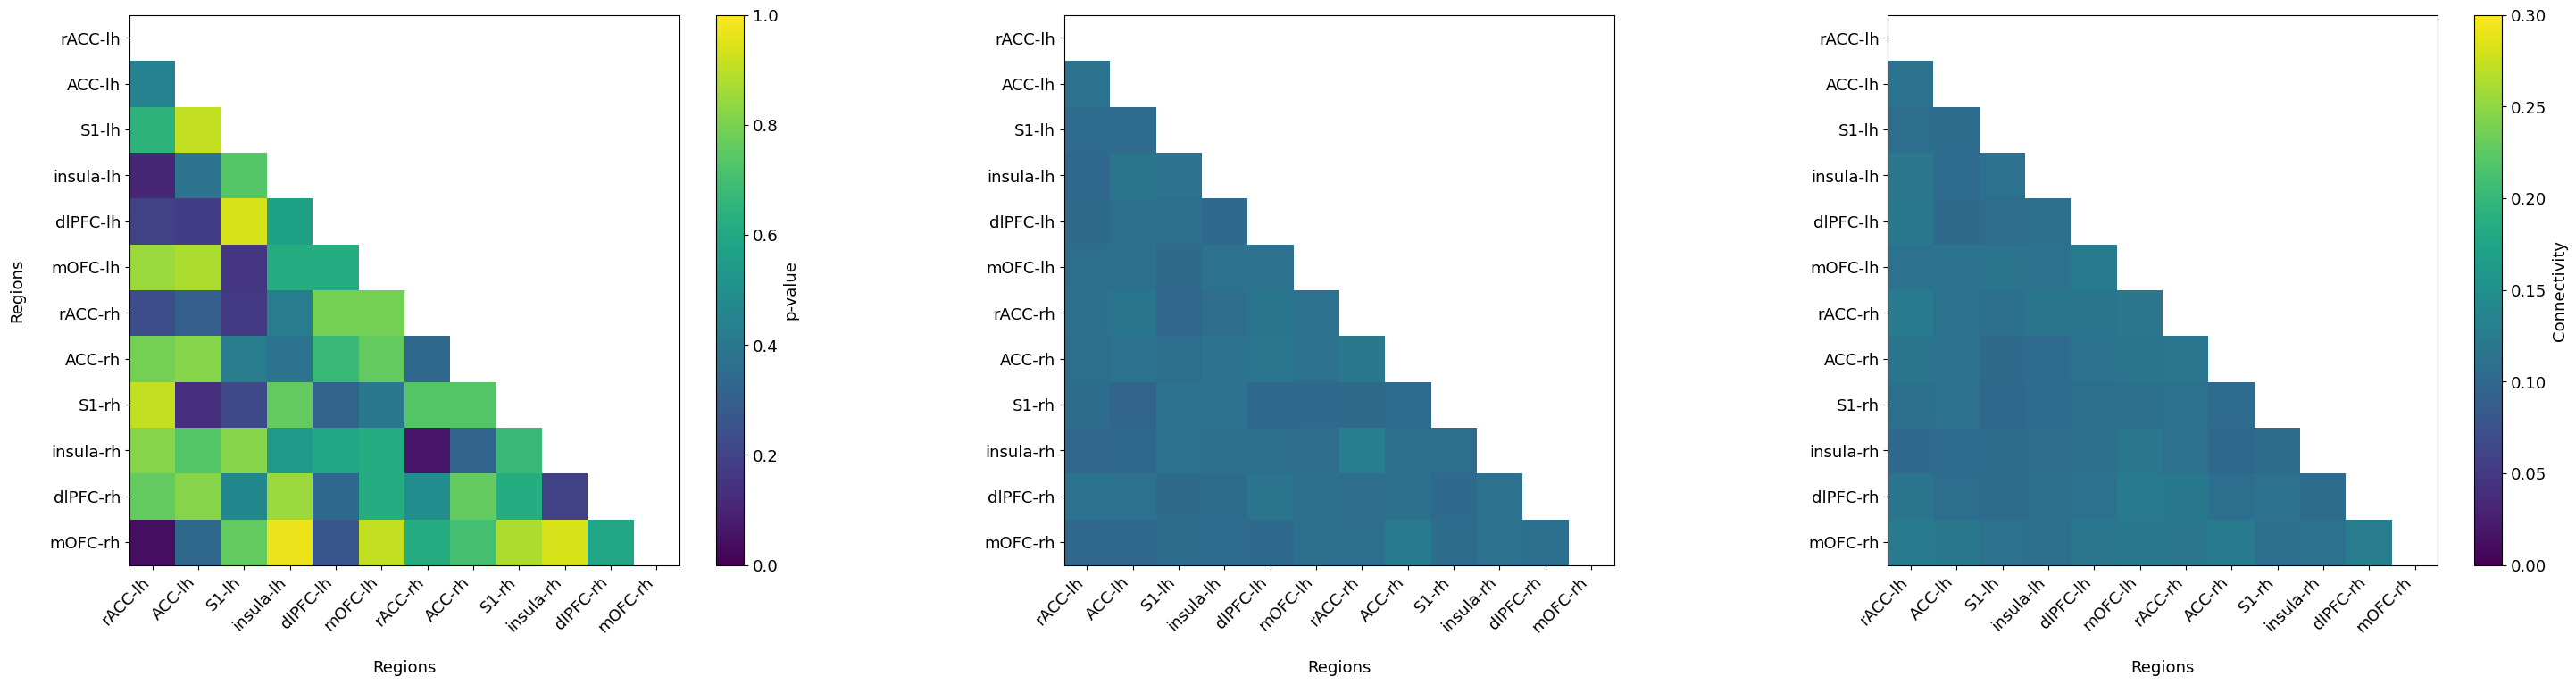

Eyes Open - CP w/ Widespread Pain vs. CP with Localized Pain - aec_pairwise - high-gamma
Num epochs: 100 vs. 211
+---------------------+---------+----------------+----------------+
|      ROI Pair       | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+---------------------+---------+----------------+----------------+
|  S1-lh <-> ACC-lh   |  0.024  | 0.105 ± 0.007  | 0.085 ± 0.004  |
| insula-lh <-> S1-lh |  0.004  | 0.113 ± 0.009  | 0.089 ± 0.004  |
+---------------------+---------+----------------+----------------+


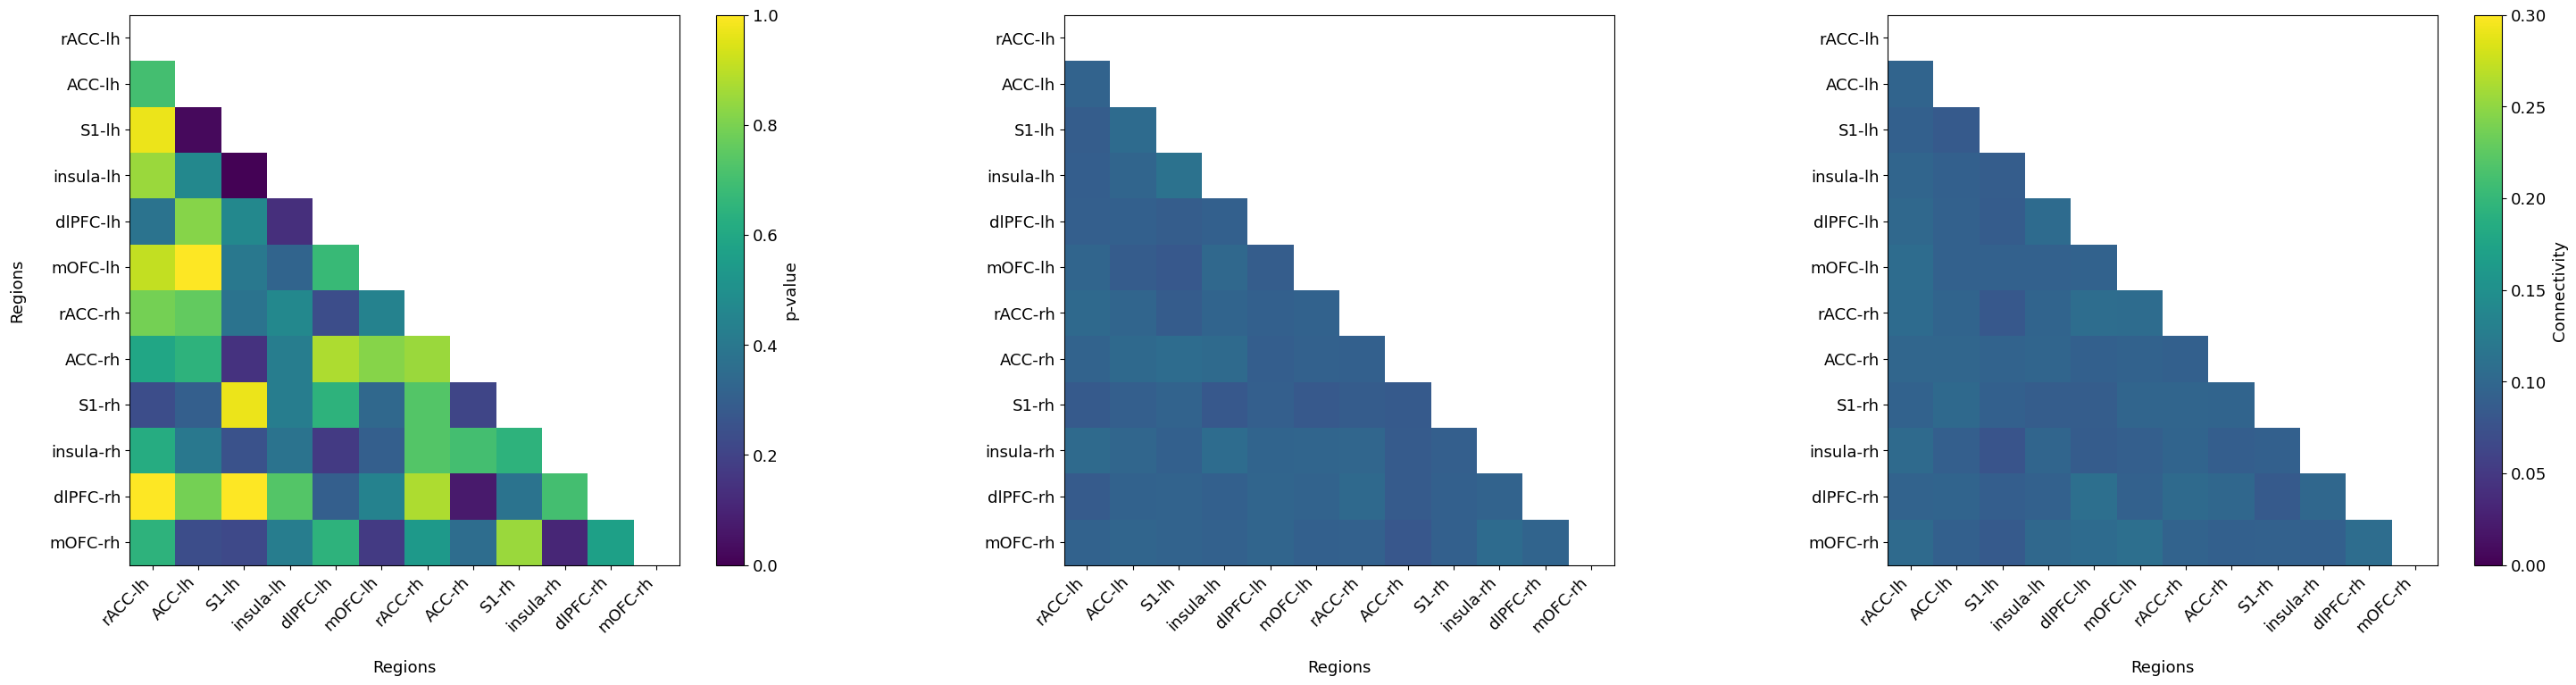

Eyes Open - CP w/ Widespread Pain vs. CP with Localized Pain - aec_symmetric - theta
Num epochs: 100 vs. 211
+--------------------+---------+----------------+----------------+
|      ROI Pair      | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+--------------------+---------+----------------+----------------+
| dlPFC-lh <-> S1-lh |  0.016  | 0.071 ± 0.012  | 0.142 ± 0.021  |
| mOFC-lh <-> S1-lh  |  0.029  |  0.2 ± 0.028   | 0.115 ± 0.017  |
+--------------------+---------+----------------+----------------+


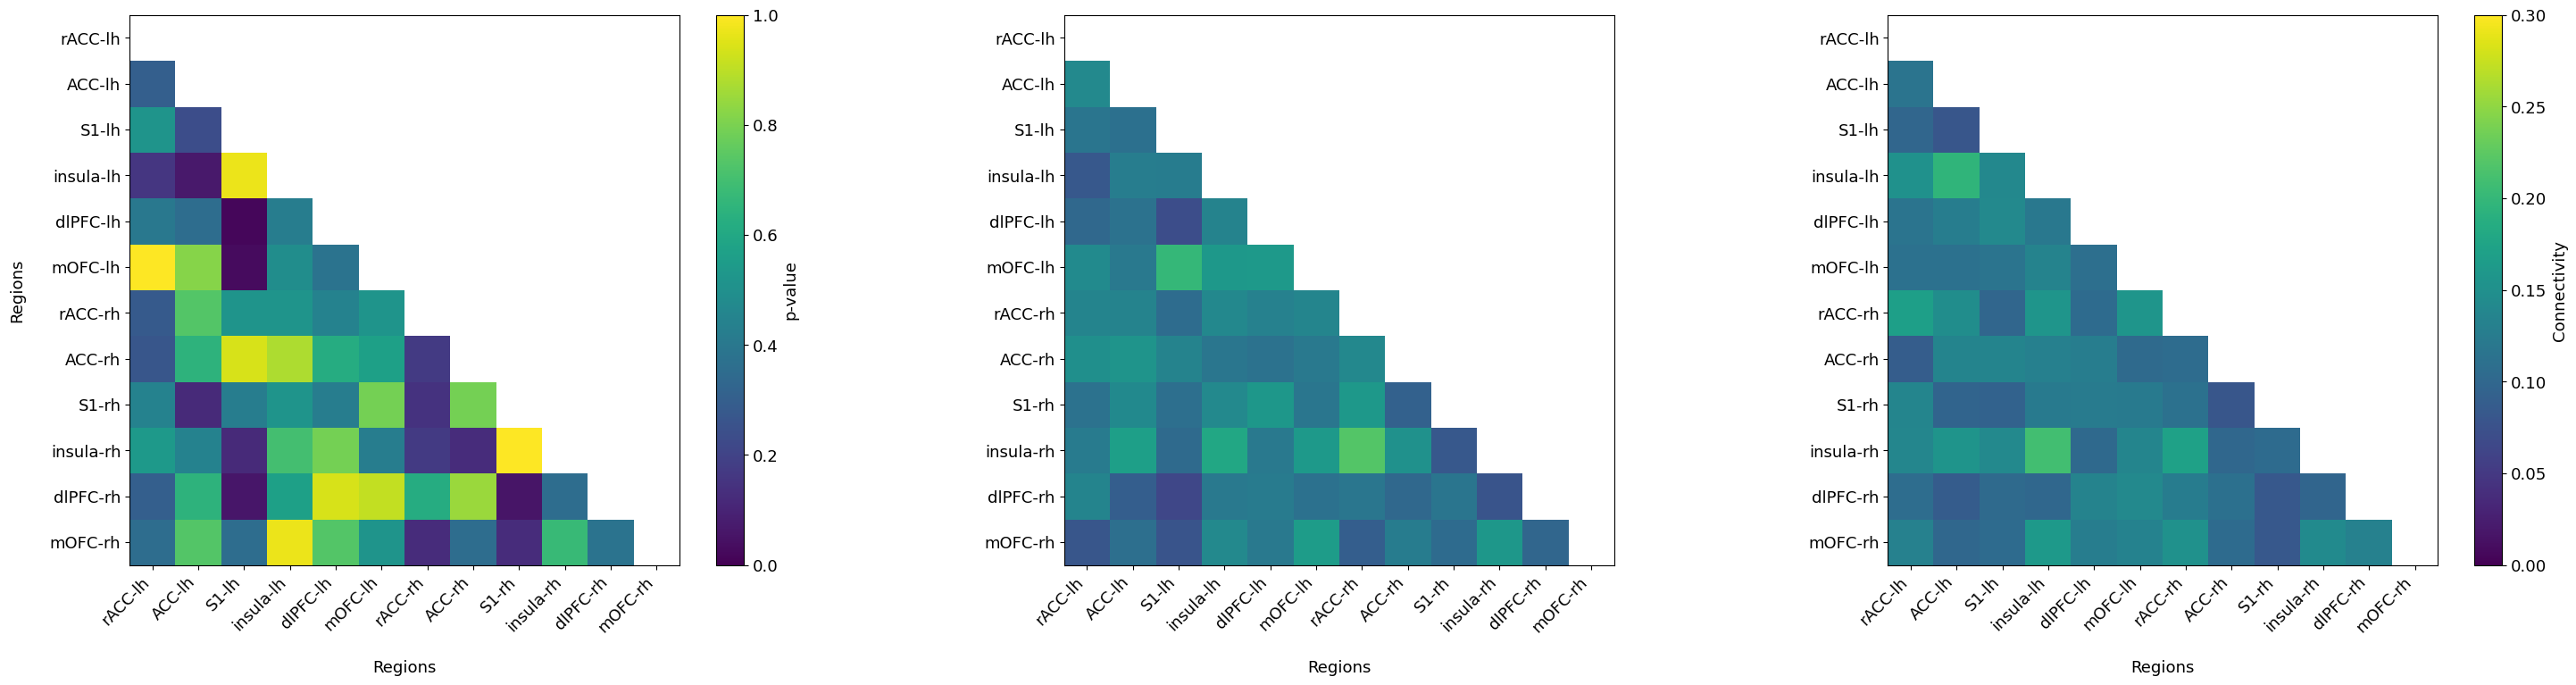

Eyes Open - CP w/ Widespread Pain vs. CP with Localized Pain - aec_symmetric - alpha
Num epochs: 100 vs. 211
+---------------------+---------+----------------+----------------+
|      ROI Pair       | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+---------------------+---------+----------------+----------------+
|  ACC-rh <-> S1-lh   |  0.012  |  0.139 ± 0.02  | 0.078 ± 0.012  |
| insula-rh <-> S1-rh |  0.015  |  0.17 ± 0.024  | 0.094 ± 0.021  |
| dlPFC-rh <-> S1-lh  |  0.013  | 0.159 ± 0.026  | 0.088 ± 0.012  |
+---------------------+---------+----------------+----------------+


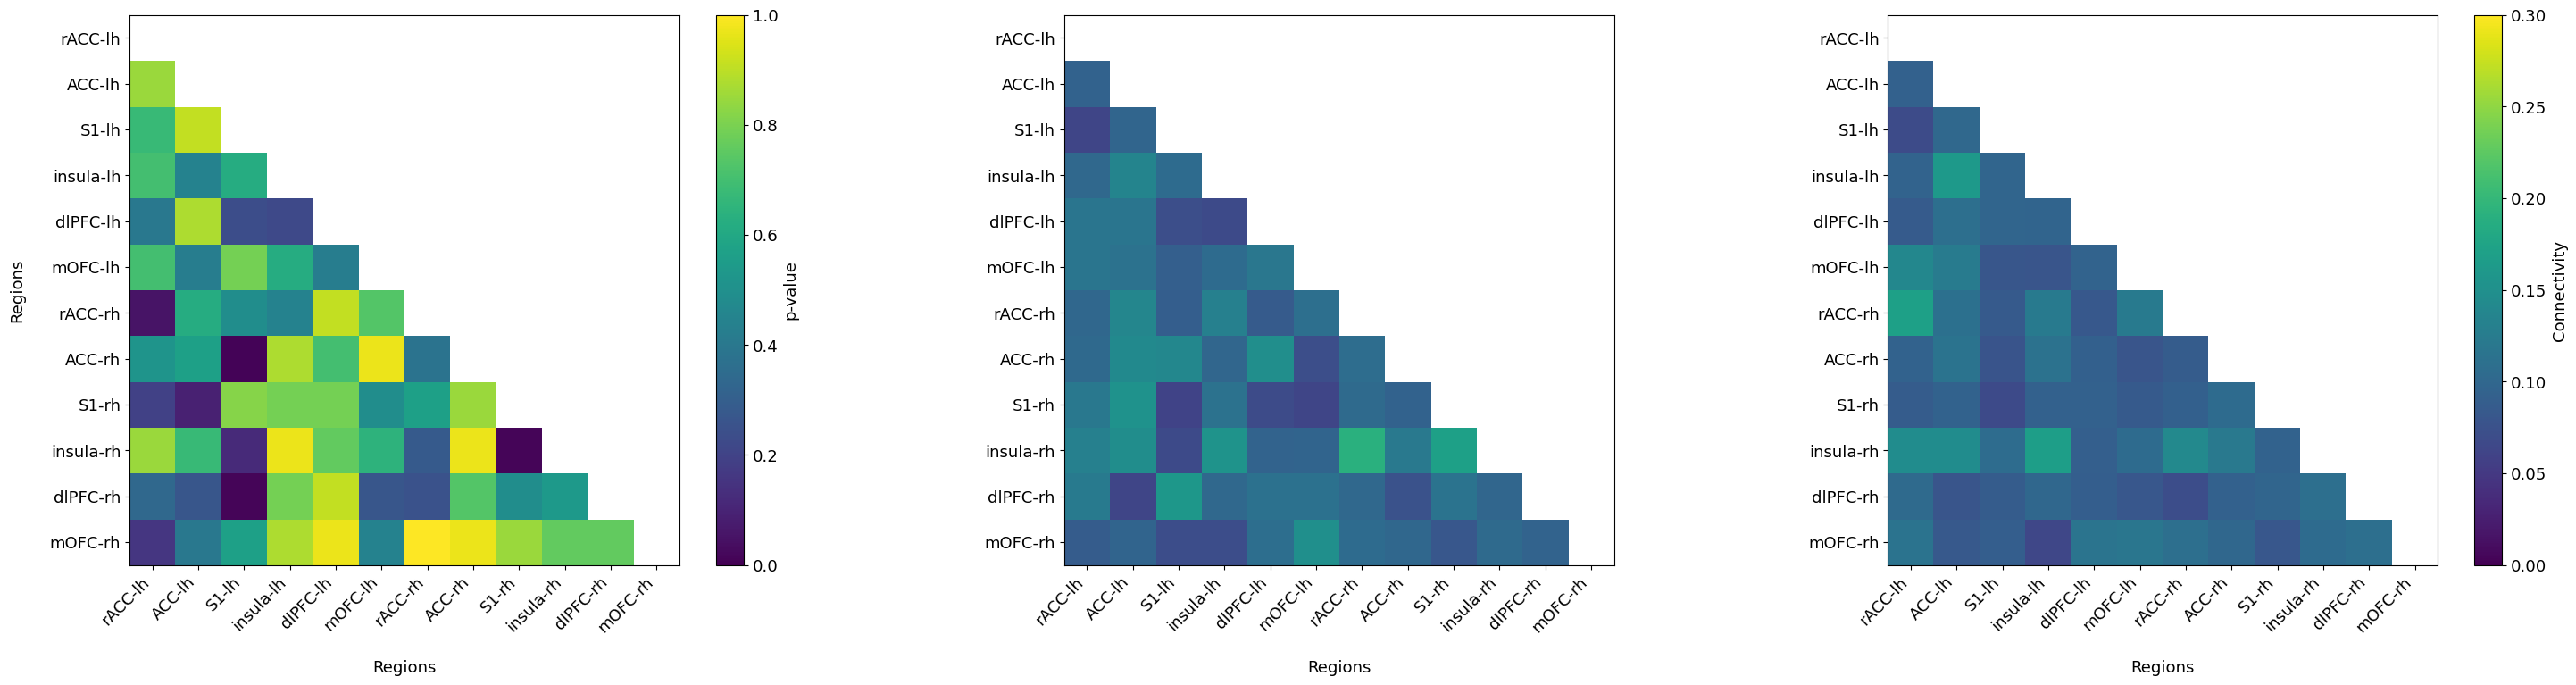

Eyes Open - CP w/ Widespread Pain vs. CP with Localized Pain - aec_symmetric - low-gamma
Num epochs: 100 vs. 211
+-----------------------+---------+----------------+----------------+
|       ROI Pair        | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+-----------------------+---------+----------------+----------------+
| mOFC-lh <-> insula-lh |  0.005  | 0.078 ± 0.008  | 0.042 ± 0.008  |
| insula-rh <-> rACC-rh |  0.027  | 0.157 ± 0.021  | 0.103 ± 0.014  |
| insula-rh <-> ACC-rh  |  0.005  | 0.103 ± 0.011  |  0.058 ± 0.01  |
+-----------------------+---------+----------------+----------------+


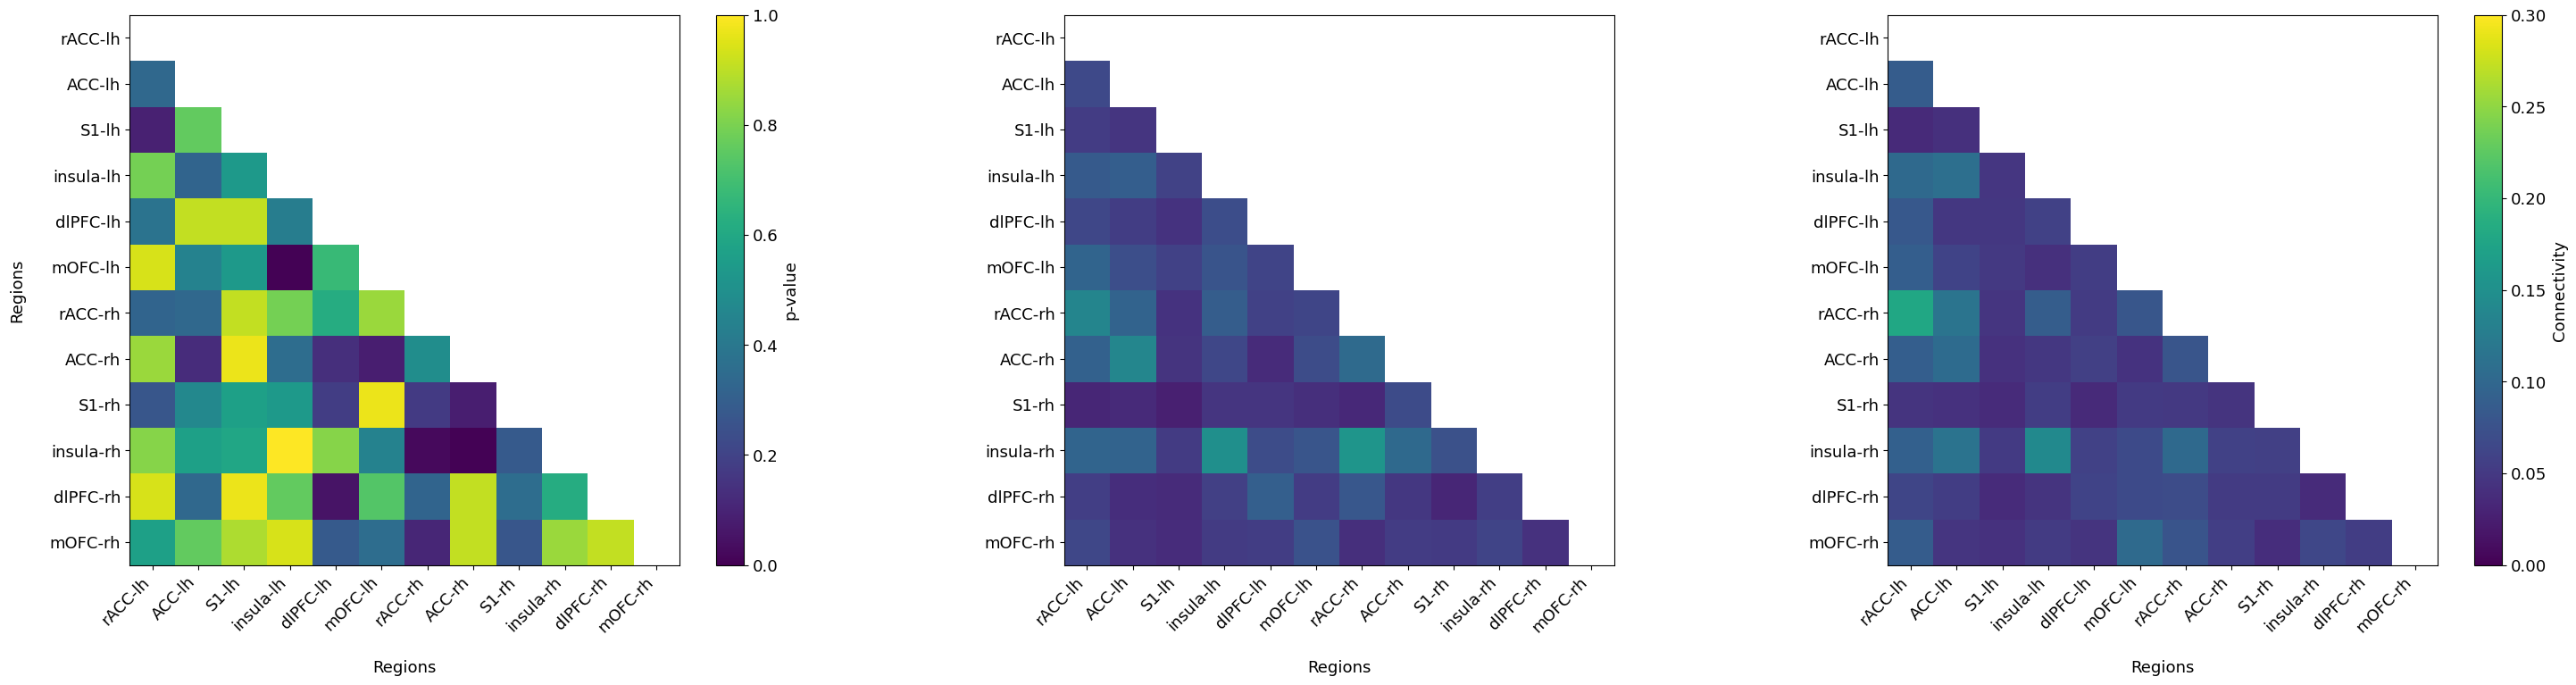

Eyes Open - CP w/ Widespread Pain vs. CP with Localized Pain - aec_symmetric - high-gamma
Num epochs: 100 vs. 211
+-----------------------+---------+----------------+----------------+
|       ROI Pair        | P-Value | Mean ± SEM (1) | Mean ± SEM (2) |
+-----------------------+---------+----------------+----------------+
| mOFC-lh <-> insula-lh |  0.018  | 0.093 ± 0.014  | 0.056 ± 0.007  |
|  ACC-rh <-> dlPFC-lh  |  0.039  | 0.065 ± 0.009  | 0.041 ± 0.008  |
+-----------------------+---------+----------------+----------------+


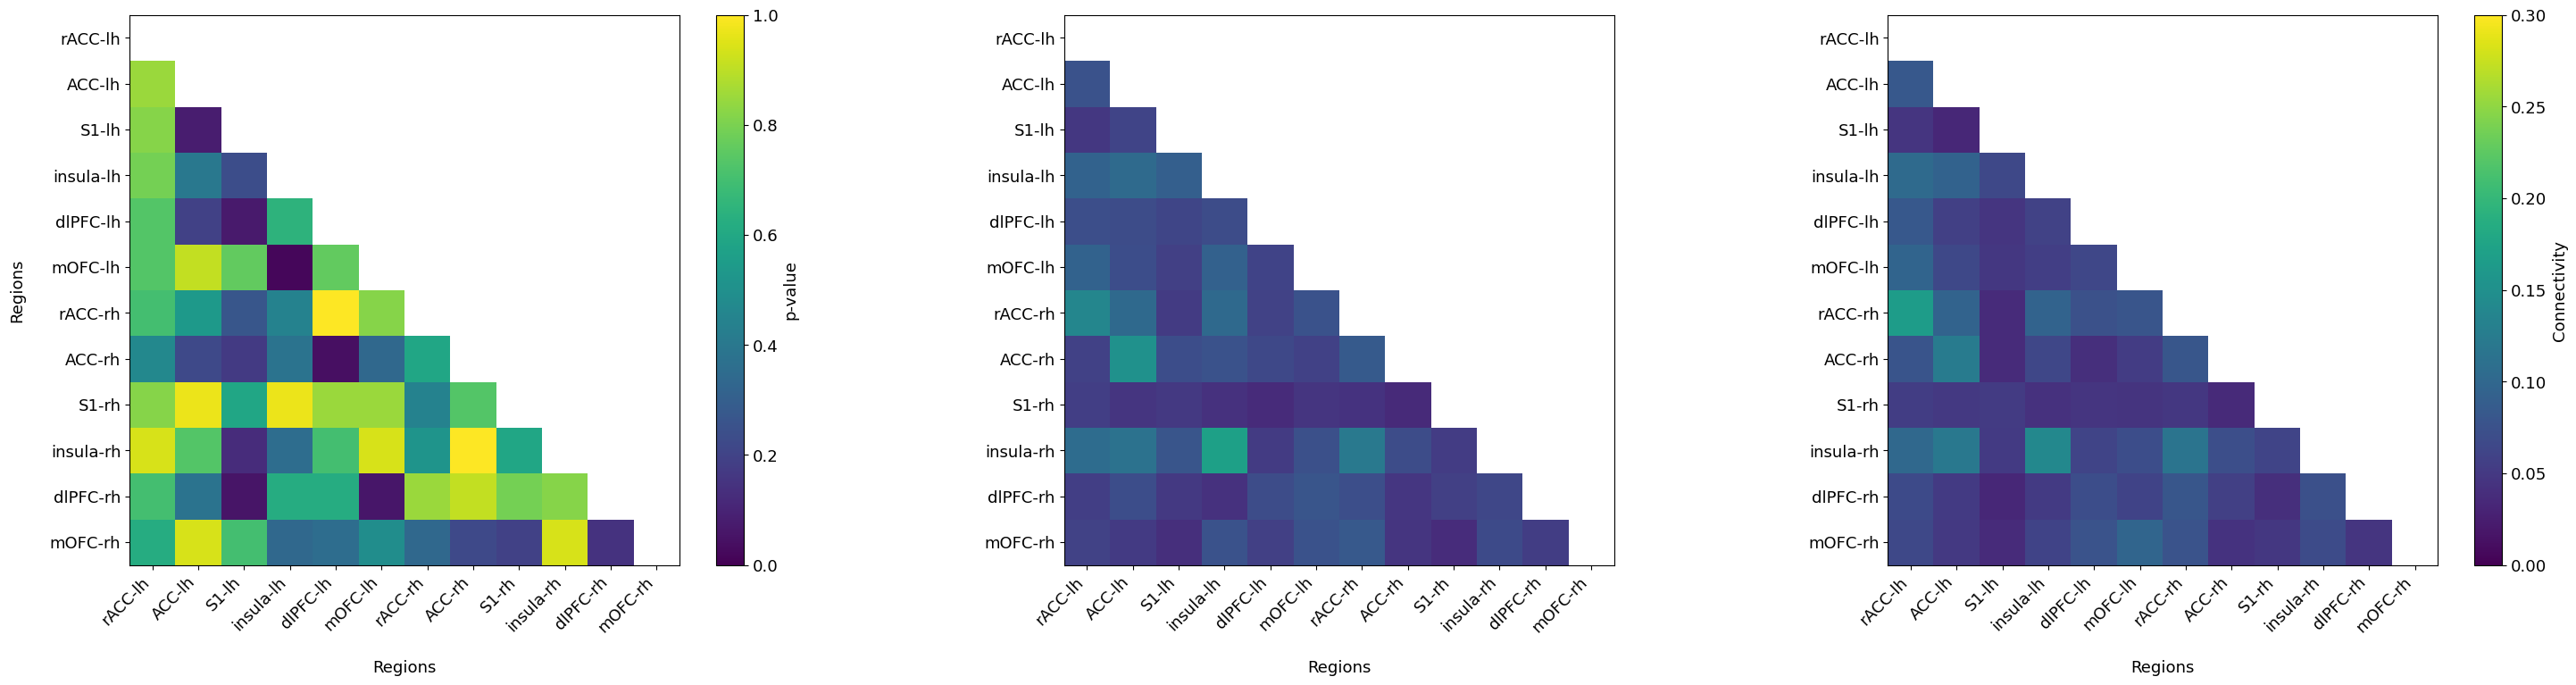

In [ ]:
# CP Widespread Pain Hand HS. vs CP without Widespread Pain
these_group_names = ["CP w/ Widespread Pain", "CP with Localized Pain","Mann_Whitney_U_test"]
these_group_cons = [group_con_CP_WSP, group_con_CP_No_WSP]

for condition in conditions:
    # Make a directory for the stats
    stats_save_path = save_path / f"CP_WSP_vs_CP_No_WSP_{condition}"
    os.makedirs(stats_save_path, exist_ok=True)

    for method in con_methods:
        for band in band_names:
            # Select groups for mann-whitney
            print(f"{condition} - {these_group_names[0]} vs. {these_group_names[1]} - {method} - {band}")
            group1_stack = these_group_cons[0][condition][method][band]
            group2_stack = these_group_cons[1][condition][method][band]

            nepochs_1 = these_group_cons[0][condition]['num_epochs']
            nepochs_2 = these_group_cons[1][condition]['num_epochs']
            print(f"Num epochs: {nepochs_1} vs. {nepochs_2}")
            
            # Compute the Mann-Whitney U test
            p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test(
                group1_stack, group2_stack,roi_names,method=method)

            # Plotting            
            # Gather the information for plotting
            plot_kwargs= dict(
                method=method,
                band=band, 
                roi_names=roi_acronyms,
                condition=condition,
                group_names=these_group_names,
                nepochs=[nepochs_1, nepochs_2],
                titles=["CP w/ WSP vs. CP w/o WSP",
                        these_group_names[0], 
                        these_group_names[1], ],
                save_names=[these_group_names[0], 
                            these_group_names[1],
                            "Mann_Whitney_U_test"],
                save_path=stats_save_path,
                )           
            
            fc.plot_connectivity_and_stats(means_1,
                                           means_2,
                                           sem_1,
                                           sem_2,
                                           p_values,
                                           **plot_kwargs,
                                           save_fig=True,
                                           highlight_pvals=highlight_pvals,
                                        #    min_fc_val=min_fc_val,
                                           set_title=set_title,
                                           show_fc_vals=show_fc_vals,
            )

            if "aec" in method and plot_brain:
                # Convert ROI names to labels
                labels = [
                    mne.read_labels_from_annot(
                        subject, regexp=roi, subjects_dir=subjects_dir
                    )[0]
                    for roi in roi_names
                ]

                # Load the inverse
                inv = None
                if "Eyes" not in condition:
                    inv = utils.unpickle_data(
                        zscored_epochs_data_path / f"{sub_id}_inv.pkl"
                    )
                elif condition == "Eyes Open":
                    inv = utils.unpickle_data(
                        EO_resting_data_path / f"{sub_id}_inv.pkl"
                    )
                elif condition == "Eyes Closed":
                    inv = utils.unpickle_data(
                        EC_resting_data_path / f"{sub_id}_inv.pkl"
                    )

                fc.plot_degree(
                    p_values, 
                    title=f"{plot_kwargs['titles'][0]} | {condition} | {band} | ({method} method, {nepochs_1} vs. {nepochs_2} trials)",
                    labels=labels, 
                    inv=inv,
                )
                fc.plot_degree(
                    means_1, 
                    title=f"{plot_kwargs['titles'][1]} | {condition} | {band} | ({method} method, {nepochs_1} trials)",
                    labels=labels, 
                    inv=inv,
                )
                fc.plot_degree(
                    means_2, 
                    title=f"{plot_kwargs['titles'][2]} | {condition} | {band} | ({method} method, {nepochs_2} trials)",
                    labels=labels, 
                    inv=inv,
                )

            # fc.plot_connectivity_circle(con_data, **plot_kwargs, save_path=save_path)

In [ ]:
# CP Widespread Pain Hand HS. vs Healthy Control Hand HS
these_group_names = ["CP w/ Widespread Pain", "Healthy Control","Mann_Whitney_U_test"]
these_group_cons = [group_con_CP_WSP, group_con_HC]

for condition in conditions:
    # Make a directory for the stats
    stats_save_path = save_path / f"CP_WSP_vs_HC_{condition}"
    os.makedirs(stats_save_path, exist_ok=True)

    for method in con_methods:
        for band in band_names:
            # Select groups for mann-whitney
            print(f"{condition} - {these_group_names[0]} vs. {these_group_names[1]} - {method} - {band}")
            group1_stack = these_group_cons[0][condition][method][band]
            group2_stack = these_group_cons[1][condition][method][band]

            nepochs_1 = these_group_cons[0][condition]['num_epochs']
            nepochs_2 = these_group_cons[1][condition]['num_epochs']
            print(f"Num epochs: {nepochs_1} vs. {nepochs_2}")

            # Compute the Mann-Whitney U test
            p_values, means_1, sem_1, means_2, sem_2 = fc.mann_whitney_test(
                group1_stack, group2_stack,roi_names,method=method)

            # Plotting            
            # Gather the information for plotting
            plot_kwargs= dict(
                method=method,
                band=band, 
                roi_names=roi_acronyms,
                condition=condition,
                group_names=these_group_names,
                nepochs=[nepochs_1, nepochs_2],
                titles=["CP with WSP vs. HC",
                        these_group_names[0], 
                        these_group_names[1],],
                save_names=[these_group_names[0], 
                            these_group_names[1],
                            "Mann_Whitney_U_test"],
                save_path=stats_save_path,
                )           
            
            fc.plot_connectivity_and_stats(means_1,
                                           means_2,
                                           sem_1,
                                           sem_2,
                                           p_values,
                                           **plot_kwargs,
                                           save_fig=True,
                                           highlight_pvals=highlight_pvals,
                                        #    min_fc_val=min_fc_val,
                                           set_title=set_title,
                                           show_fc_vals=show_fc_vals,
            )
            
            if "aec" in method and plot_brain:
                # Convert ROI names to labels
                labels = [
                    mne.read_labels_from_annot(
                        subject, regexp=roi, subjects_dir=subjects_dir
                    )[0]
                    for roi in roi_names
                ]

                # Load the inverse
                inv = None
                if "Eyes" not in condition:
                    inv = utils.unpickle_data(
                        zscored_epochs_data_path / f"{sub_id}_inv.pkl"
                    )
                elif condition == "Eyes Open":
                    inv = utils.unpickle_data(
                        EO_resting_data_path / f"{sub_id}_inv.pkl"
                    )
                elif condition == "Eyes Closed":
                    inv = utils.unpickle_data(
                        EC_resting_data_path / f"{sub_id}_inv.pkl"
                    )

                fc.plot_degree(
                    p_values, 
                    title=f"{plot_kwargs['titles'][0]} | {condition} | {band} | ({method} method, {nepochs_1} vs. {nepochs_2} trials)",
                    labels=labels, 
                    inv=inv,
                )
                fc.plot_degree(
                    means_1, 
                    title=f"{plot_kwargs['titles'][1]} | {condition} | {band} | ({method} method, {nepochs_1} trials)",
                    labels=labels, 
                    inv=inv,
                )
                fc.plot_degree(
                    means_2, 
                    title=f"{plot_kwargs['titles'][2]} | {condition} | {band} | ({method} method, {nepochs_2} trials)",
                    labels=labels, 
                    inv=inv,
                )

            # fc.plot_connectivity_circle(con_data, **plot_kwargs, save_path=save_path)

NameError: name 'group_con_HC' is not defined